In [2]:
import sys
sys.path.extend(['..', '../bgspy'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt

from bgspy.utils import get_files, load_pickle, rel_error, abs_error
from bgspy.optim import optim_diagnotics_plot

In [4]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [5]:
from bgspy.likelihood import negll_simplex

def neutral_params(nt, nf, pi0, mu):
    W = np.zeros((nt, nf))
    #W[0, :] = 1  # all neutral
    theta = np.empty(2 + nt*nf)
    theta[0] = pi0
    theta[1] = mu
    theta[2:] = W.flat
    return theta

def null_negloglik(fit):
    Y = fit.Y
    nS, nD = Y.T
    pi0 = nD.sum() / (nS.sum()+nD.sum())
    log_pi = np.log(pi0)
    ll = np.sum(nD*log_pi + nS*np.log1p(-np.exp(log_pi)))
    return -ll

def lik_ratio(fit):
    ll_full = -fit.nll_
    ll_reduced = -null_negloglik(fit)
    LR = -2 * (ll_reduced - ll_full)
    return LR


/home/vsb/projects/bprime/bgspy/data.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


## Load Data

In [11]:
DIR_default = '../slim_sims/chrombgs/runs/conserved_cds_utrs_phastcons_merged__hapmap__fixed__demography/mle/default/1000000/N__1000/synthetic__chr1_chr2_chr3_chr4_chr5/'
DIR_full = '../slim_sims/chrombgs/runs/conserved_cds_utrs_phastcons_merged__hapmap__fixed__demography/mle/full/1000000/N__1000/synthetic__chr1_chr2_chr3_chr4_chr5//'
mles = get_files(DIR_default, '_mle.pkl') + get_files(DIR_full, '_mle.pkl')

In [12]:
from copy import copy
import warnings
from tqdm import tqdm
import os

def merge_chrom_metadata(md, ignore=('chrom', 'chrom_length', 'subs', 'dfe', 'recmap_file', 'seqlens_file', 'sim_tree_file')):
    """
    The simulation trees come in with *a lot* of metadata. This is all in a dictionary
    per-individul-sim, but each MLE fit is on a synthetic chromosome. So this checks
    that all metadata not in ignore (i.e. will be unique per sim ) is the same.
    and outputs it.
    """
    params = []
    def unpack(x):
        if isinstance(x, list) and len(x) == 1:
            return x[0]
        return x
    # the Bs file is packaged with the chromosome metedata, extract it first
    bs_file = md.pop('bs_file')
    for chrom, dat in md.items():
        row = {k: unpack(dat[k]) for k in dat.keys() if k not in ignore}
        if len(params):
            assert list(row.values()) == list(params[-1].values()), (row, params[-1])
        params.append(row)
    md = params[-1]
    md['bs_file'] = bs_file
    return md


def read_fixed_sh_sim_fits(mle_files):
    rows = []
    for fit_file in tqdm(mle_files):
        fits = load_pickle(fit_file)
        mb, mbp = fits['mb'], fits['mbp']
        mb_md = merge_chrom_metadata(mb.metadata)
        mbp_md = merge_chrom_metadata(mbp.metadata)        
        assert mb_md == mbp_md, "B and B' having differing metadata!"
        row = dict(mbp_md)
        # now get the fits for each chromosome
        for model, model_fit in fits.items():
            LR = lik_ratio(model_fit)
            row = copy(row)
            theta = model_fit.param_dict()
            row['model'] = model
            row['LR'] = LR
            row[f'est_mu'] = model_fit.mle_mu
            row[f'est_pi0'] = model_fit.mle_pi0
            sim_sh = int(np.round(np.log10(row['sh']), 8))
            W = np.array(model_fit.mle_W)
            with np.errstate(under='ignore'):
                row['R2'] = model_fit.R2()
                row['est_mean_sh'] = np.average(model_fit.t, weights=W[:, 0])
            row['features'] = '-'.join(model_fit.features)
            row['sh_rel_error'] = rel_error(row['est_mean_sh'], row['sh'], as_percent=False)
            row['fit'] = model_fit
            row['negll'] = model_fit.nll_
            rows.append(row)
    return pd.DataFrame(rows)


d = read_fixed_sh_sim_fits(mles)
d['track_type'] = [dict(default='conserved only track', full='whole genome track')[x.replace('bmap__', '').replace('.pkl', '')] for x in d['bs_file']]
model_labels = dict(mb='classic B', mbp="new B'")
d['type'] = [f"{track}, {model_labels[model]}, {exp}" for track, model, exp in zip(d['track_type'], d['model'], d['exp_rate'])]
d['log10_sh'] = np.log10(d['sh'])
d['log10_est_mean_sh'] = np.log10(d['est_mean_sh'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1120/1120 [00:17<00:00, 62.83it/s]


In [39]:
d.columns

Index(['sim_mu', 'N', 'T_exp', 'annot_file', 'exp_rate', 'h', 'mu', 'name',
       'sh', 'bs_file', 'model', 'LR', 'est_mu', 'est_pi0', 'R2',
       'est_mean_sh', 'features', 'sh_rel_error', 'fit', 'negll', 'track_type',
       'type', 'log10_sh', 'log10_est_mean_sh'],
      dtype='object')

In [52]:
dg = d.groupby(['sim_mu', 'N', 'annot_file', 'h', 'mu', 'name', 'sh', 'bs_file', 'features', 'track_type', 'type', 'model']).mean().reset_index()

/tmp/ipykernel_63826/746880589.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dg = d.groupby(['sim_mu', 'N', 'annot_file', 'h', 'mu', 'name', 'sh', 'bs_file', 'features', 'track_type', 'type', 'model']).mean().reset_index()


In [53]:
dg['sh_rel_error'] = [rel_error(est, real, as_percent=False) for est, real in zip(dg['est_mean_sh'], dg['sh'])]
dg['sh_abs_error'] = [abs_error(est, real) for est, real in zip(dg['est_mean_sh'], dg['sh'])]
dg['bias'] = [(est-real) for est, real in zip(dg['est_mean_sh'], dg['sh'])]

In [54]:
dg.tail()

,sim_mu,N,annot_file,h,mu,name,sh,bs_file,features,track_type,...,est_mu,est_pi0,R2,est_mean_sh,sh_rel_error,negll,log10_sh,log10_est_mean_sh,sh_abs_error,bias
219,2.500000e-07,1000,../../data/annotation/conserved_cds_utrs_phast...,0.5,1.500000e-08,conserved_cds_utrs_phastcons_merged__hapmap__f...,0.05,bmap__default.pkl,merged,conserved only track,...,1.451425e-08,0.000940,0.320390,0.039340,0.213198,1.862783e+12,-1.30103,-1.416704,0.010660,-0.010660
220,2.500000e-07,1000,../../data/annotation/conserved_cds_utrs_phast...,0.5,1.500000e-08,conserved_cds_utrs_phastcons_merged__hapmap__f...,0.05,bmap__full.pkl,merged-other,whole genome track,...,1.000000e-09,0.001200,0.194712,0.005768,0.884640,2.307798e+12,-1.30103,-2.267911,0.044232,-0.044232
221,2.500000e-07,1000,../../data/annotation/conserved_cds_utrs_phast...,0.5,1.500000e-08,conserved_cds_utrs_phastcons_merged__hapmap__f...,0.05,bmap__full.pkl,merged-other,whole genome track,...,1.000000e-09,0.000941,0.174298,0.004819,0.903615,1.863121e+12,-1.30103,-2.369823,0.045181,-0.045181
222,2.500000e-07,1000,../../data/annotation/conserved_cds_utrs_phast...,0.5,1.500000e-08,conserved_cds_utrs_phastcons_merged__hapmap__f...,0.05,bmap__full.pkl,merged-other,whole genome track,...,1.197098e-08,0.001161,0.347786,0.036854,0.262925,2.306849e+12,-1.30103,-1.449225,0.013146,-0.013146
223,2.500000e-07,1000,../../data/annotation/conserved_cds_utrs_phast...,0.5,1.500000e-08,conserved_cds_utrs_phastcons_merged__hapmap__f...,0.05,bmap__full.pkl,merged-other,whole genome track,...,1.453989e-08,0.000937,0.318360,0.038412,0.231768,1.862215e+12,-1.30103,-1.426021,0.011588,-0.011588


## Constant Demography Comparisons

In [58]:
d['type'].unique()

array(['conserved only track, classic B, 1.004',
       "conserved only track, new B', 1.004",
       'conserved only track, classic B, False',
       "conserved only track, new B', False",
       'whole genome track, classic B, 1.004',
       "whole genome track, new B', 1.004",
       'whole genome track, classic B, False',
       "whole genome track, new B', False"], dtype=object)

In [106]:
ax.get_yticklabels()

[Text(0, -10.0, '−10'),
 Text(0, -9.0, '−9'),
 Text(0, -8.0, '−8'),
 Text(0, -7.0, '−7'),
 Text(0, -6.0, '−6'),
 Text(0, -5.0, '−5'),
 Text(0, -4.0, '−4'),
 Text(0, -3.0, '−3'),
 Text(0, -2.0, '−2'),
 Text(0, -1.0, '−1'),
 Text(0, 0.0, '0')]

In [149]:
sorted(df.sh.unique())

[1e-08, 1e-05, 0.0001, 0.001, 0.005, 0.01, 0.05]

/tmp/ipykernel_63826/249159980.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x='sh', y='log10_est_mean_sh', data=df, hue='type', ax=ax, hue_order=order, ci='sd', dodge=0.2, palette=color_palette)
/tmp/ipykernel_63826/249159980.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = old_legend.legendHandles


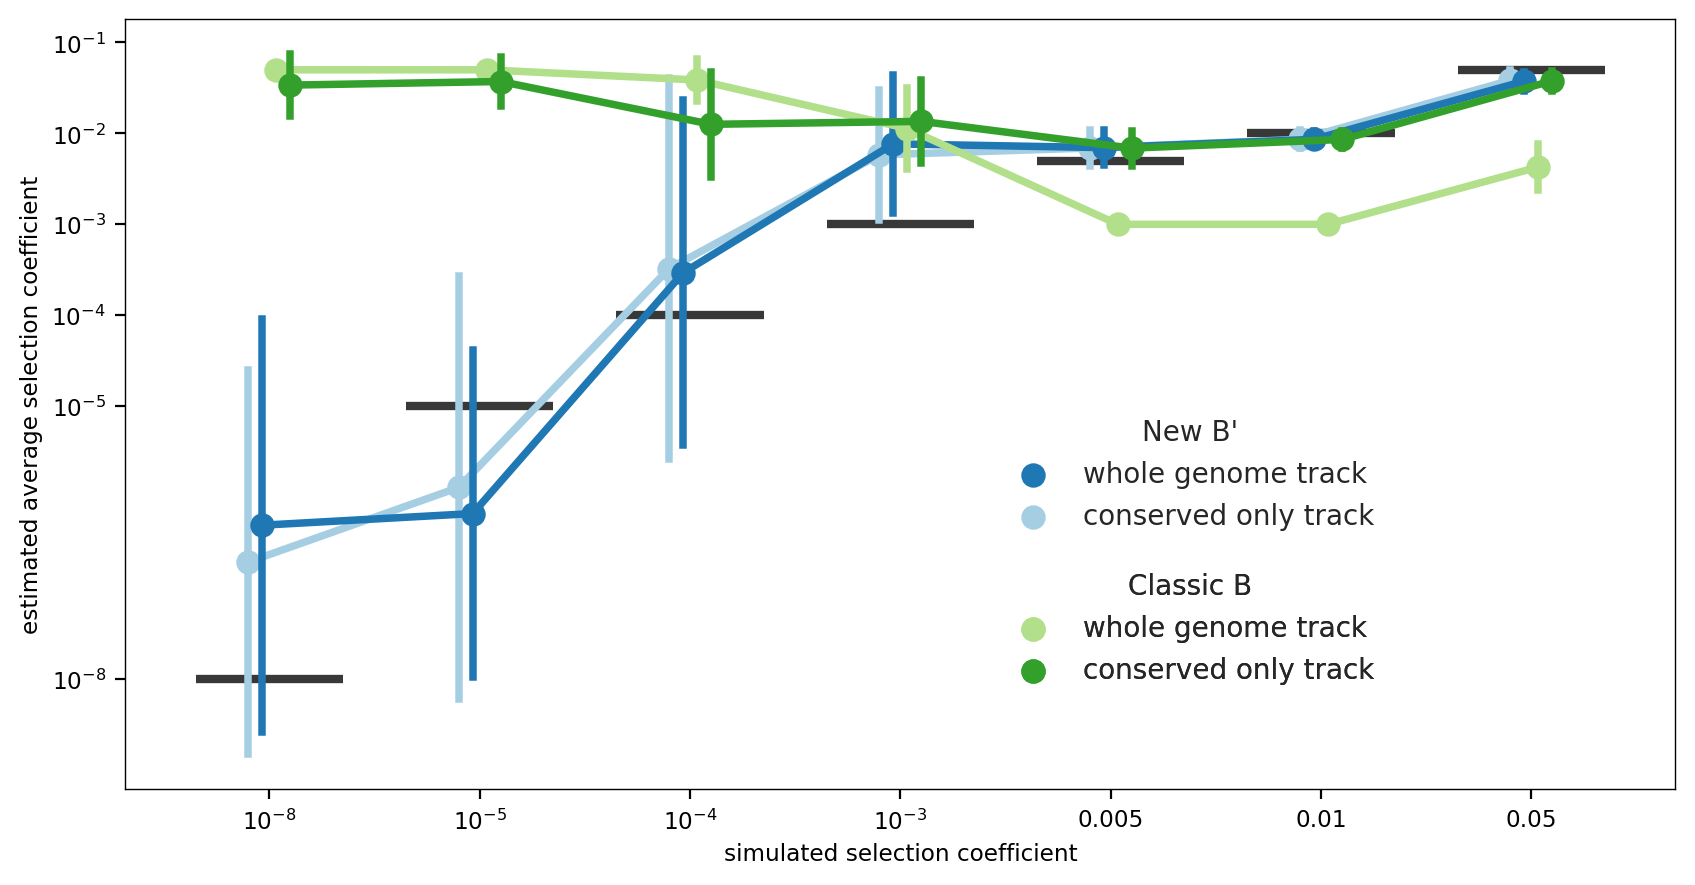

In [179]:
df = d.loc[(d['exp_rate'] == False) & (dfc['mu'] == 1.5e-8) & (dfc['h'] == 0.5)].sort_values(['type', 'model'])

order = ["conserved only track, new B', False",         
         "whole genome track, new B', False", 
         'whole genome track, classic B, False',
        'conserved only track, classic B, False',]

fig, ax = plt.subplots()
color_palette = sns.color_palette("Paired", len(order))
sns.pointplot(x='sh', y='log10_est_mean_sh', data=df, hue='type', ax=ax, hue_order=order, ci='sd', dodge=0.2, palette=color_palette)
x = {i: np.log10(float(x.get_text())) for i, x in enumerate(ax.get_xticklabels())}
#ax.scatter(x.keys(), x.values(), c='0.22', zorder=10)


xx = np.array(list(x.keys()))
#yy = np.array(list(x.values()))
w = 0.35
ax.hlines(x.values(), xx-w, xx+w, color='0.22', linewidth=3, zorder=-1)
ax.set_ylabel('estimated average selection coefficient')
ax.set_xlabel('simulated selection coefficient')

ylabs = [-1, -2, -3, -4, -5, -8]
ytick_labels = {tick: '$10^{{{}}}$'.format(int(tick)) for tick in ylabs}
ax.set_yticks(ylabs)
ax.set_yticklabels([ytick_labels.get(tick, '') for tick in ax.get_yticks()])

xx = [-1, np.log10(0.05), -2, np.log10(0.005), -3, -4, -5, -8]
xx = list(x.keys())
xtick_labels = ["$10^{-8}$", "$10^{-5}$", "$10^{-4}$", "$10^{-3}$", "0.005", "0.01", "0.05"]
ax.set_xticks(xx)
ax.set_xticklabels(xtick_labels)

old_legend = ax.legend()
ax.legend_.remove()

# Get the legend components
legend_handles = old_legend.legendHandles
legend_labels = [t.get_text().split(',')[0] for t in old_legend.get_texts()]

# Split the components into two lists
midpoint = len(legend_handles) // 2
legend_handles_1 = legend_handles[:midpoint]
legend_labels_1 = legend_labels[:midpoint]
legend_handles_2 = legend_handles[midpoint:]
legend_labels_2 = legend_labels[midpoint:]

# Create two separate legends using the lists
legend_1 = ax.legend(reversed(legend_handles_1), reversed(legend_labels_1), loc=(0.55, 0.3), title="New B'")
legend_2 = ax.legend(legend_handles_2, legend_labels_2, loc=(0.55, 0.1), title="Classic B")

# Add the legends to the plot
ax.add_artist(legend_1)
ax.add_artist(legend_2)


In [158]:
old_legend = ax.legend()

TypeError: Legend.get_legend_handler() missing 2 required positional arguments: 'legend_handler_map' and 'orig_handle'

In [ ]:
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5)]
fig, ax = plt.subplots()
sns.boxplot(x='sh', y='log10_est_mean_sh', data=df, hue='type', ax=ax, whis=False, showmeans=True)

x = {i: np.log10(float(x.get_text())) for i, x in enumerate(ax.get_xticklabels())}
ax.scatter(x.keys(), x.values(), c='r')
#ax.semilogy()
ax.set_ylabel('estimated average selection coefficient')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

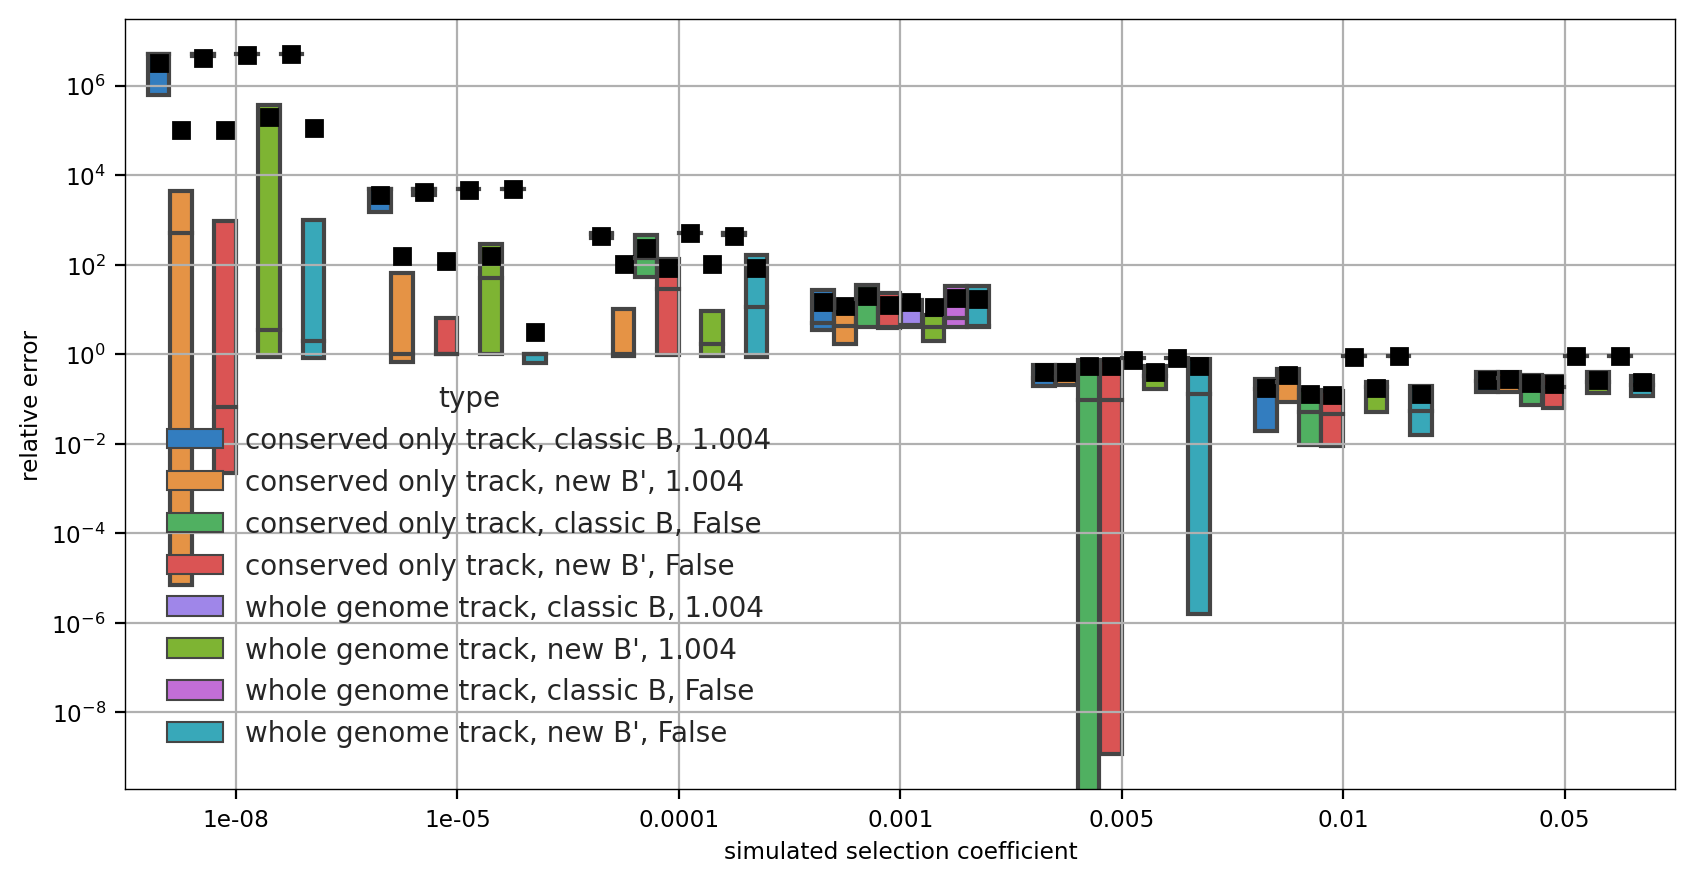

In [17]:
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5)]
fig, ax = plt.subplots()
sns.boxplot(x='sh', y='sh_rel_error', data=df, hue='type', ax=ax, whis=False, showmeans=True)
ax.set_yscale('log')
ax.grid()
ax.set_ylabel('relative error')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

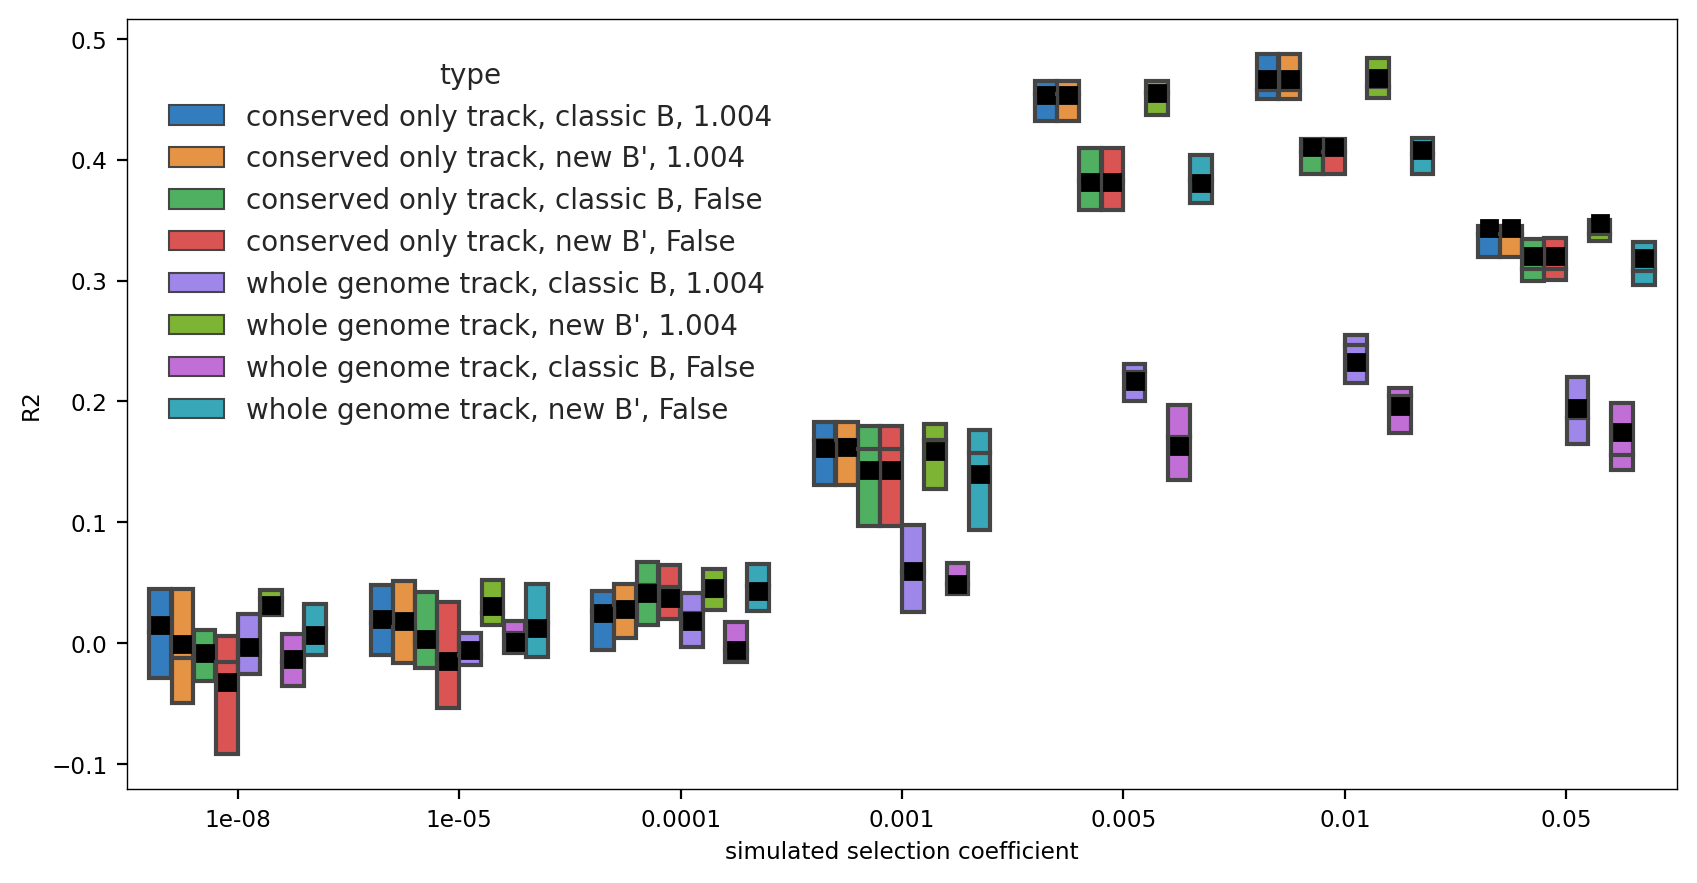

In [18]:
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5)]
fig, ax = plt.subplots()
sns.boxplot(x='sh', y='R2', data=df, hue='type', ax=ax, whis=False, showmeans=True)
#ax.set_yscale('symlog')
ax.set_ylabel('R2')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

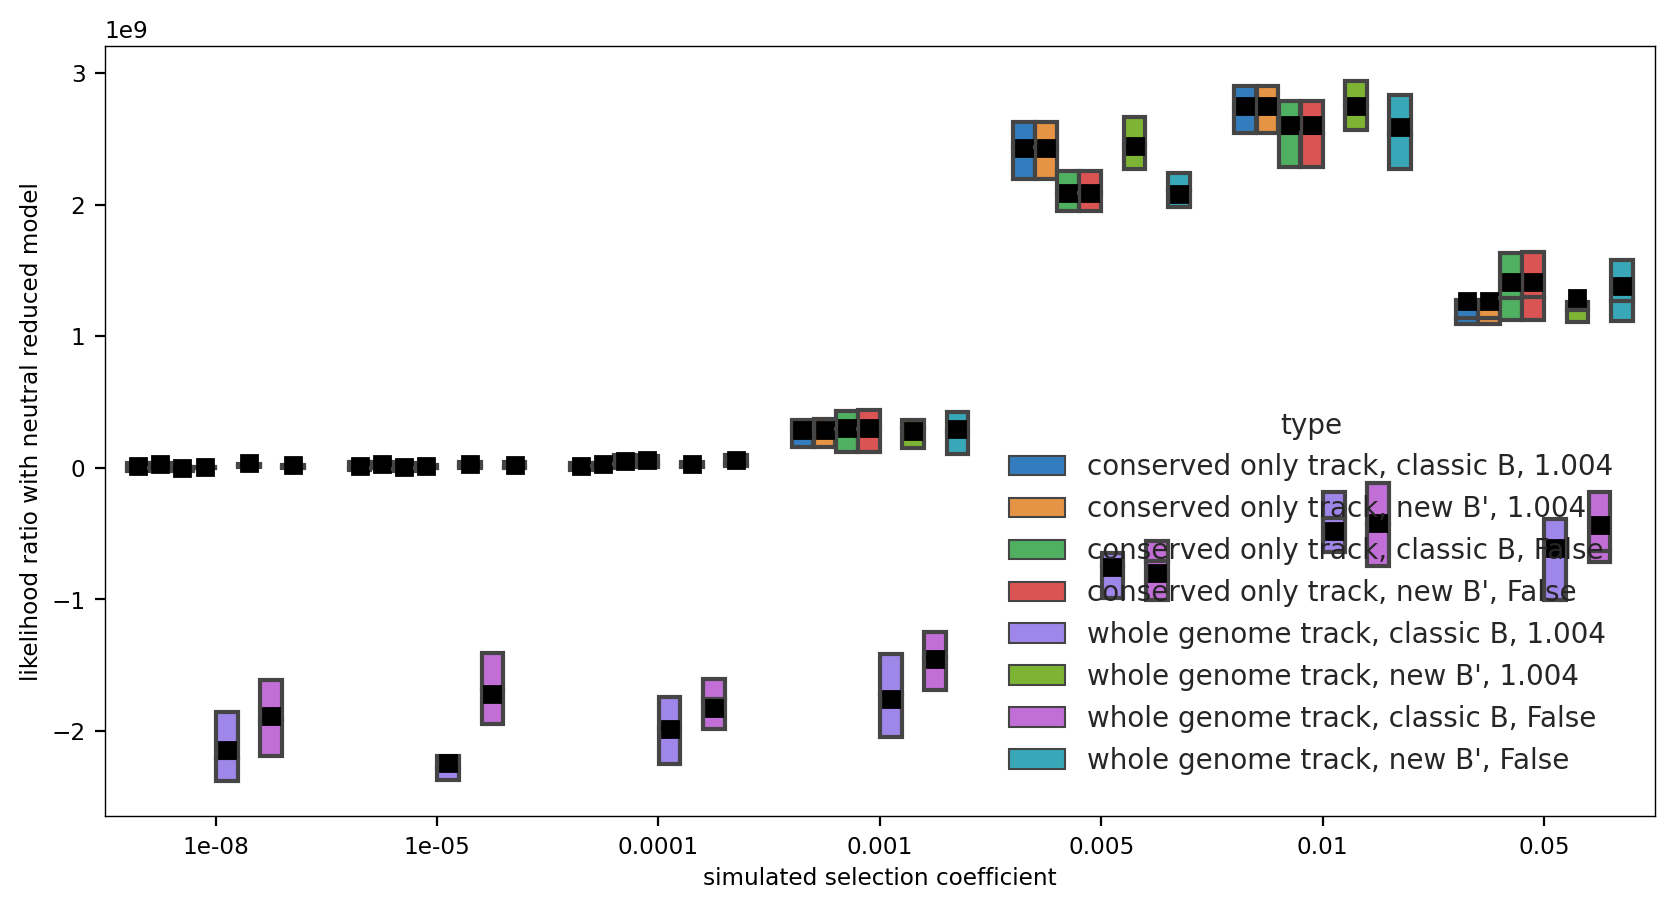

In [19]:
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5)]

fig, ax = plt.subplots()
sns.boxplot(x='sh', y='LR', data=df, hue='type', ax=ax, whis=False, showmeans=True)
#ax.set_yscale('symlog')
ax.set_ylabel('likelihood ratio with neutral reduced model')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

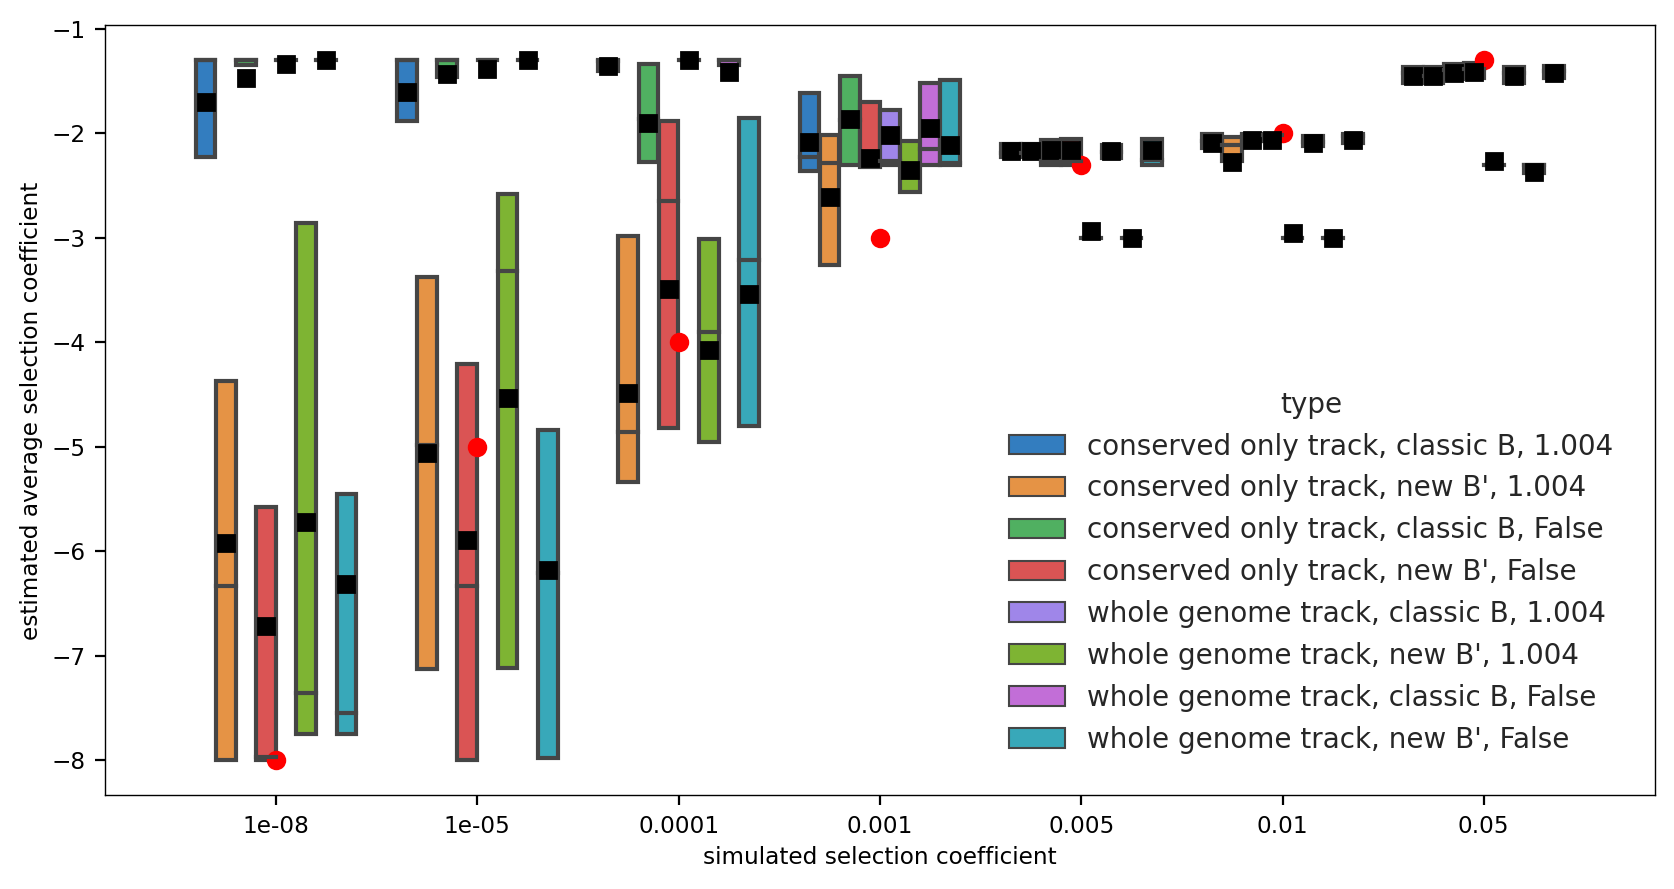

In [20]:
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5)]
fig, ax = plt.subplots()
sns.boxplot(x='sh', y='log10_est_mean_sh', data=df, hue='type', ax=ax, whis=False, showmeans=True)

x = {i: np.log10(float(x.get_text())) for i, x in enumerate(ax.get_xticklabels())}
ax.scatter(x.keys(), x.values(), c='r')
#ax.semilogy()
ax.set_ylabel('estimated average selection coefficient')
ax.set_xlabel('simulated selection coefficient')

In [24]:
df.columns

Index(['sim_mu', 'N', 'T_exp', 'annot_file', 'exp_rate', 'h', 'mu', 'name',
       'sh', 'bs_file', 'model', 'LR', 'est_mu', 'est_pi0', 'R2',
       'est_mean_sh', 'features', 'sh_rel_error', 'fit', 'negll', 'track_type',
       'type', 'log10_sh', 'log10_est_mean_sh'],
      dtype='object')

In [33]:
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5)]
df.groupby(['mu', 'sh', 'type']).mean()

/tmp/ipykernel_63826/1276159119.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['mu', 'sh', 'type']).mean()


sim_mu  \
mu           sh           type                                                   
1.500000e-08 1.000000e-08 conserved only track, classic B, 1.004  2.500000e-07   
                          conserved only track, classic B, False  2.500000e-07   
                          conserved only track, new B', 1.004     2.500000e-07   
                          conserved only track, new B', False     2.500000e-07   
                          whole genome track, classic B, 1.004    2.500000e-07   
                          whole genome track, classic B, False    2.500000e-07   
                          whole genome track, new B', 1.004       2.500000e-07   
                          whole genome track, new B', False       2.500000e-07   
             1.000000e-05 conserved only track, classic B, 1.004  2.500000e-07   
                          conserved only track, classic B, False  2.500000e-07   
                          conserved only track, new B', 1.004     2.500000e-07   
                          conserved only track, new B', False     2.500000e-07   
                          whole genome track, classic B, 1.004    2.500000e-07   
                          whole genome track, classic B, False    2.500000e-07   
                          whole genome track, new B', 1.004       2.500000e-07   
                          whole genome track, new B', False       2.500000e-07   
             1.000000e-04 conserved only track, classic B, 1.004  2.500000e-07   
                          conserved only track, classic B, False  2.500000e-07   
                          conserved only track, new B', 1.004     2.500000e-07   
                          conserved only track, new B', False     2.500000e-07   
                          whole genome track, classic B, 1.004    2.500000e-07   
                          whole genome track, classic B, False    2.500000e-07   
                          whole genome track, new B', 1.004       2.500000e-07   
                          whole genome track, new B', False       2.500000e-07   
             1.000000e-03 conserved only track, classic B, 1.004  2.500000e-07   
                          conserved only track, classic B, False  2.500000e-07   
                          conserved only track, new B', 1.004     2.500000e-07   
                          conserved only track, new B', False     2.500000e-07   
                          whole genome track, classic B, 1.004    2.500000e-07   
                          whole genome track, classic B, False    2.500000e-07   
                          whole genome track, new B', 1.004       2.500000e-07   
                          whole genome track, new B', False       2.500000e-07   
             5.000000e-03 conserved only track, classic B, 1.004  2.500000e-07   
                          conserved only track, classic B, False  2.500000e-07   
                          conserved only track, new B', 1.004     2.500000e-07   
                          conserved only track, new B', False     2.500000e-07   
                          whole genome track, classic B, 1.004    2.500000e-07   
                          whole genome track, classic B, False    2.500000e-07   
                          whole genome track, new B', 1.004       2.500000e-07   
                          whole genome track, new B', False       2.500000e-07   
             1.000000e-02 conserved only track, classic B, 1.004  2.500000e-07   
                          conserved only track, classic B, False  2.500000e-07   
                          conserved only track, new B', 1.004     2.500000e-07   
                          conserved only track, new B', False     2.500000e-07   
                          whole genome track, classic B, 1.004    2.500000e-07   
                          whole genome track, classic B, False    2.500000e-07   
                          whole genome track, new B', 1.004       2.500000e-07   
                          whole genome track, new B', 

Text(0.5, 0, 'simulated selection coefficient')

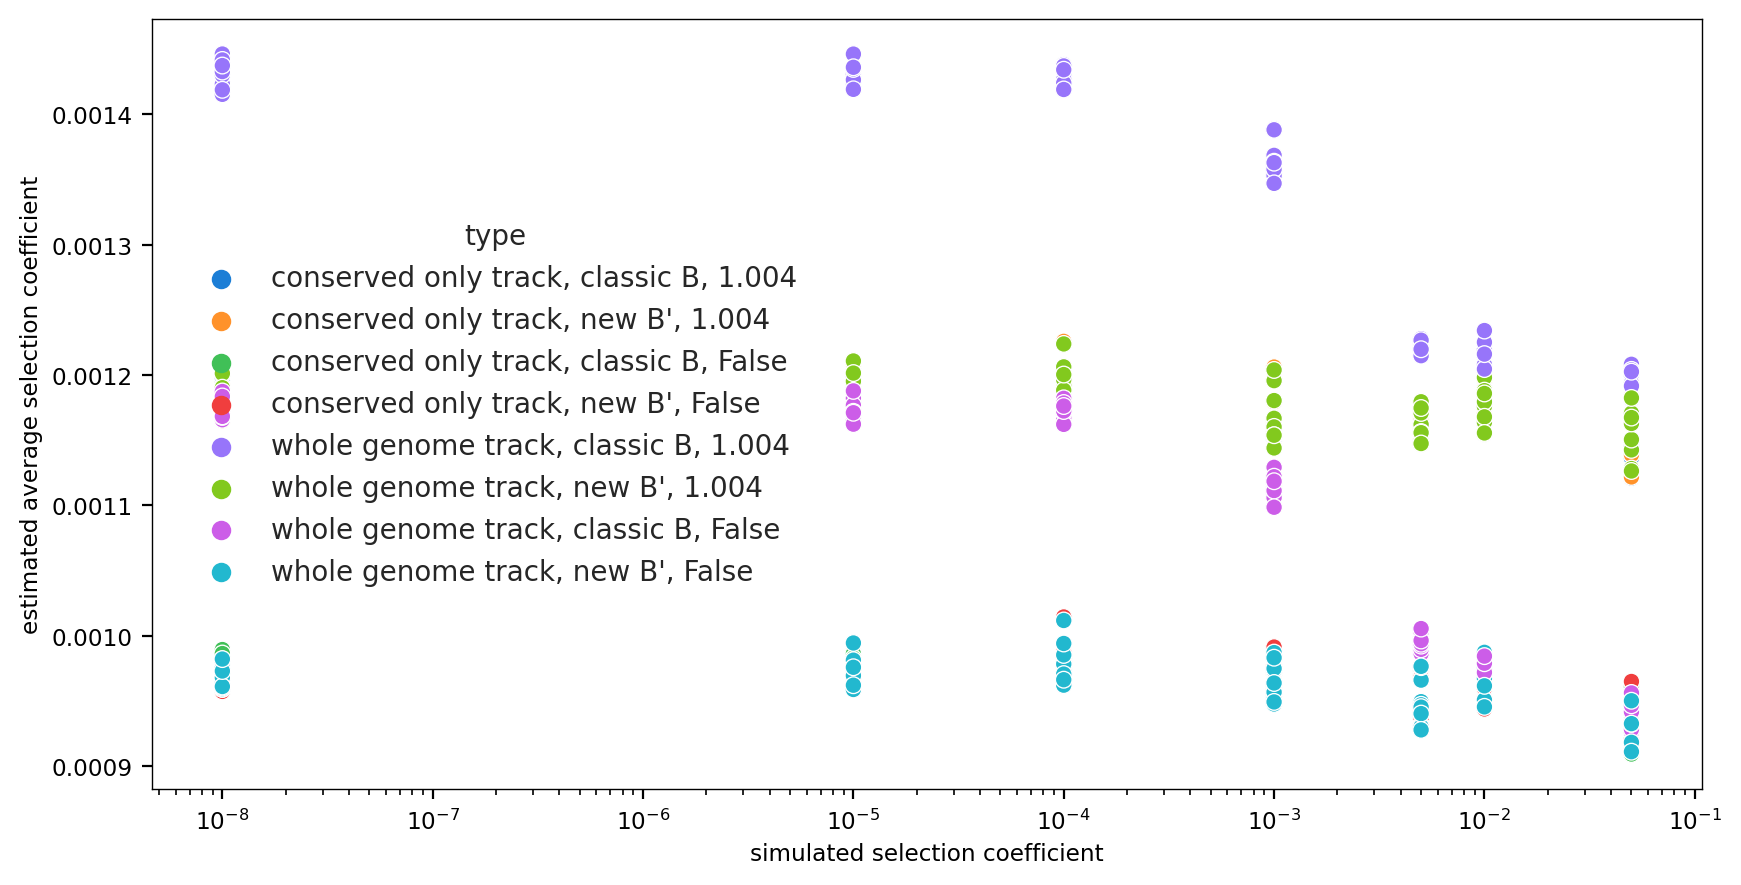

In [30]:
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5)]
fig, ax = plt.subplots()
sns.scatterplot(x='sh', y='est_pi0', data=df, hue='type', ax=ax)
ax.semilogx()
ax.set_ylabel('estimated average selection coefficient')
ax.set_xlabel('simulated selection coefficient')

Text(0.5, 0, 'simulated selection coefficient')

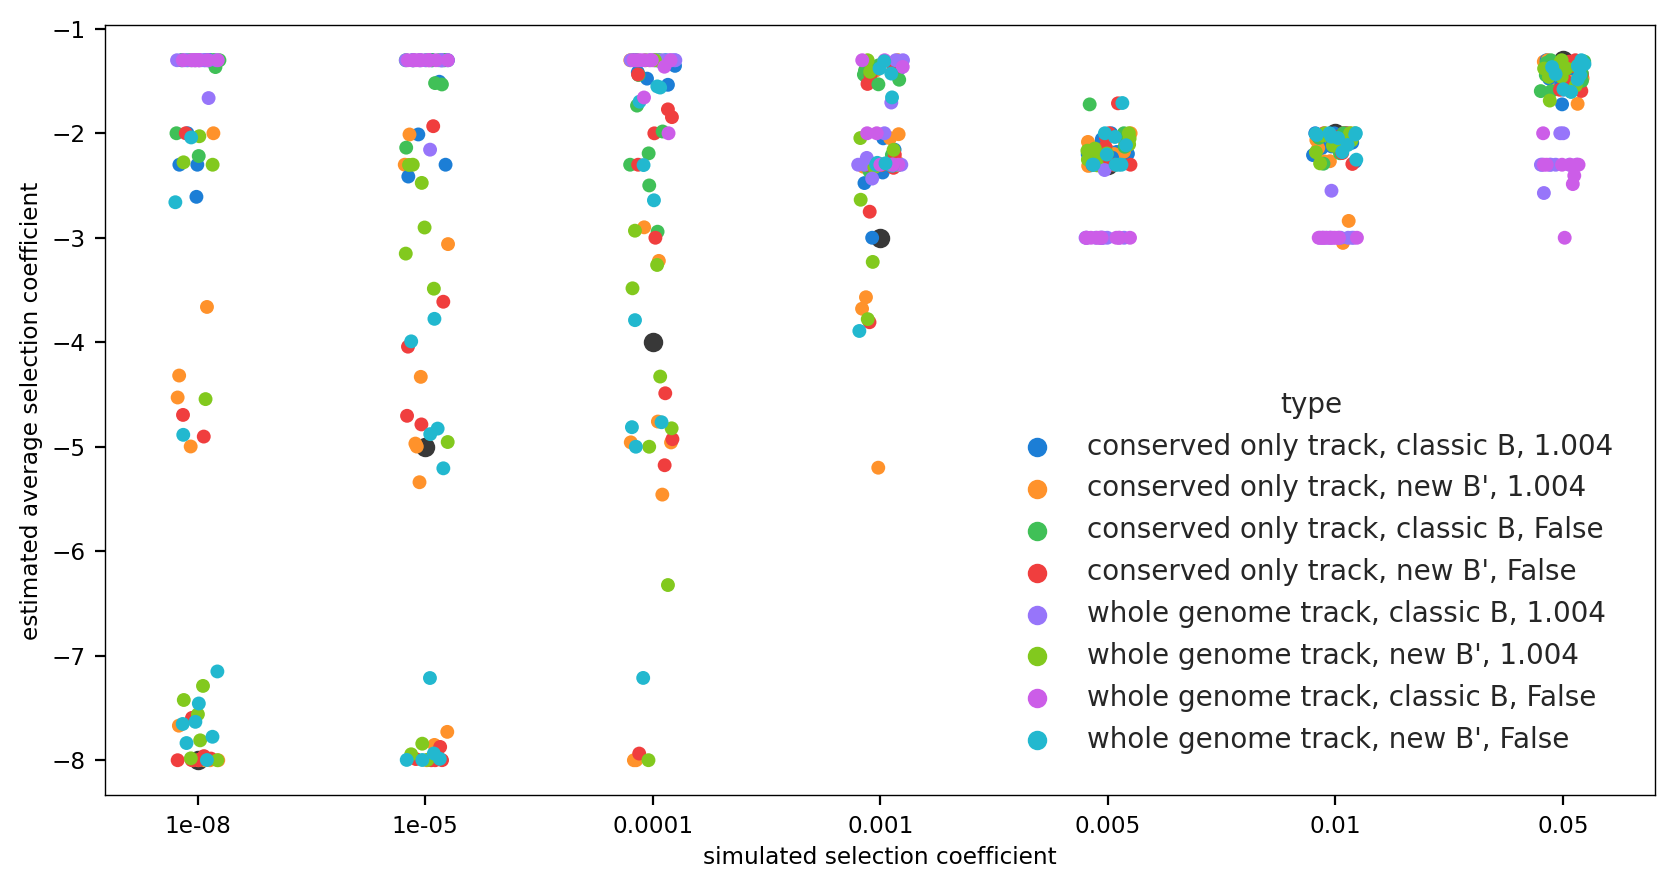

In [21]:
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5)]
fig, ax = plt.subplots()
sns.stripplot(x='sh', y='log10_est_mean_sh', data=df, hue='type', ax=ax)

x = {i: np.log10(float(x.get_text())) for i, x in enumerate(ax.get_xticklabels())}
ax.scatter(x.keys(), x.values(), c='0.22')
#ax.semilogy()
ax.set_ylabel('estimated average selection coefficient')
ax.set_xlabel('simulated selection coefficient')

In [215]:
sh = 0.01
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5) & (d['sh'] == sh) & (d['model'] == 'mbp') & (d['model'] == 'mbp') & (d['track_type'] == 'whole genome track')]
df['est_mu'].mean(), df['mu'].unique()

(1.2177610523627367e-08, array([1.5e-08]))

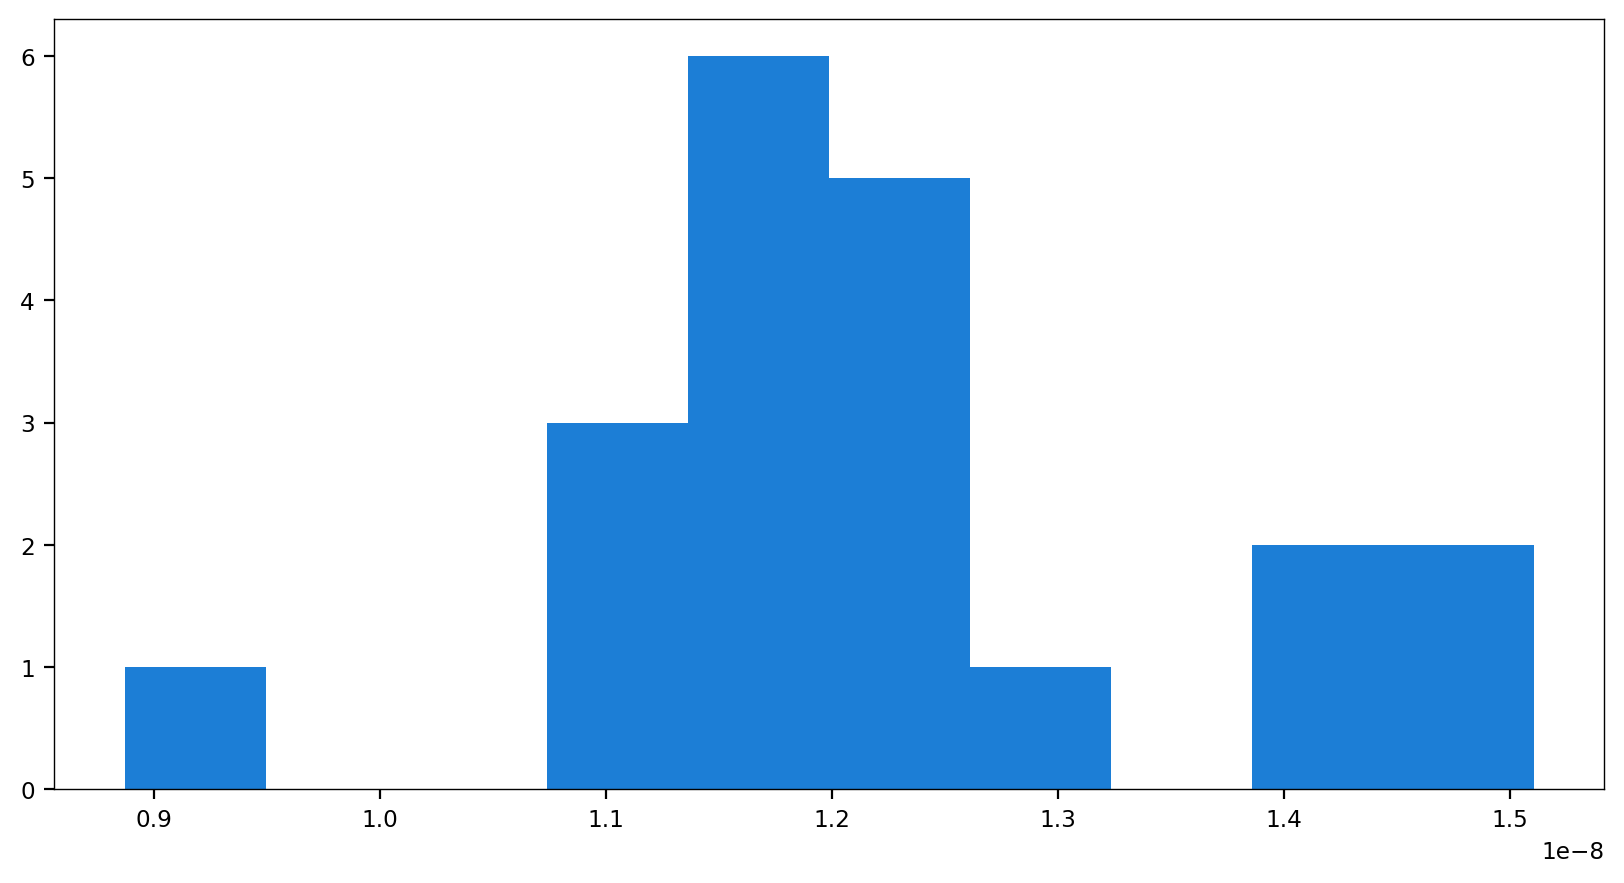

In [217]:
_ = plt.hist(df['est_mu'], 10)

In [151]:
sh = 0.0001
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5) & (d['sh'] == sh) & (d['model'] == 'mbp') & (d['model'] == 'mbp') & (d['track_type'] == 'conserved only track')]
df['est_mean_sh'].median(), df['sh'].unique()

(0.0004051163454059597, array([0.0001]))

In [176]:
len([N]*(10*N - T_ESP))

9300

Text(0.5, 0, 'generations (in N=1000 generations)')

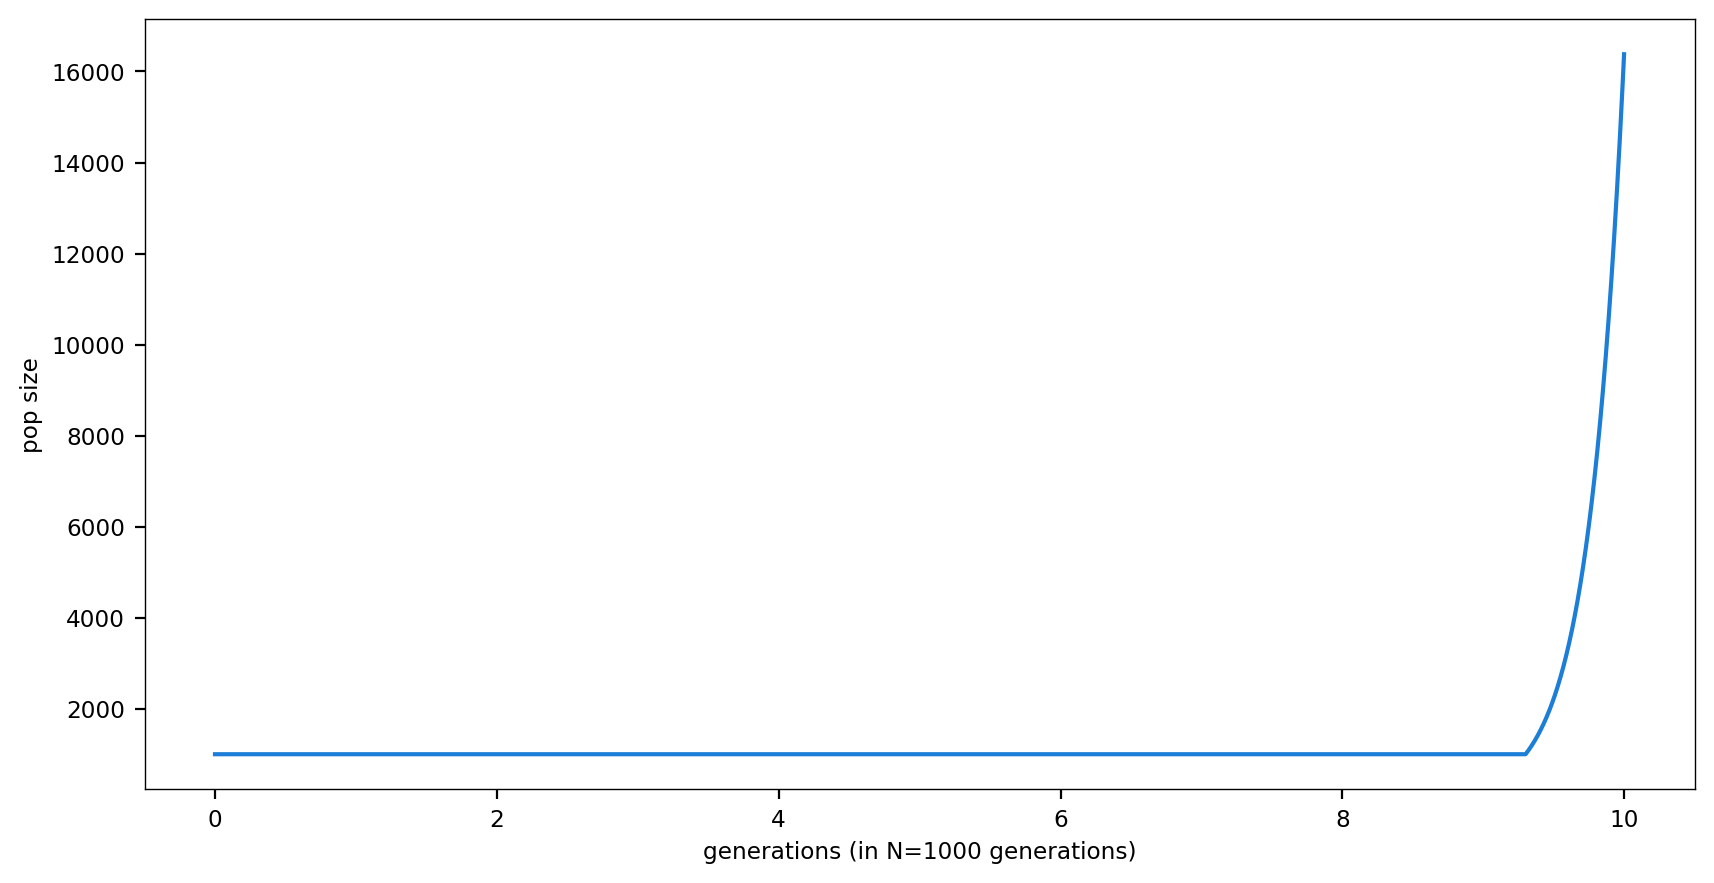

In [183]:
rEU = 0.40 / 100 
TEU = 21.2e3 / 30

T_ESP = 700

N = 1000
x = np.arange(10*N)
x_exp = np.arange(T_ESP)
y = [N]*(10*N - T_ESP) + (NEU * np.exp(rEU*x_exp)).tolist()
plt.plot(x / 1000, y)
plt.ylabel("pop size")
plt.xlabel(f"generations (in N={N} generations)")

In [185]:
(10*N - T_ESP) / N

9.3

(<Figure size 2000x1000 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

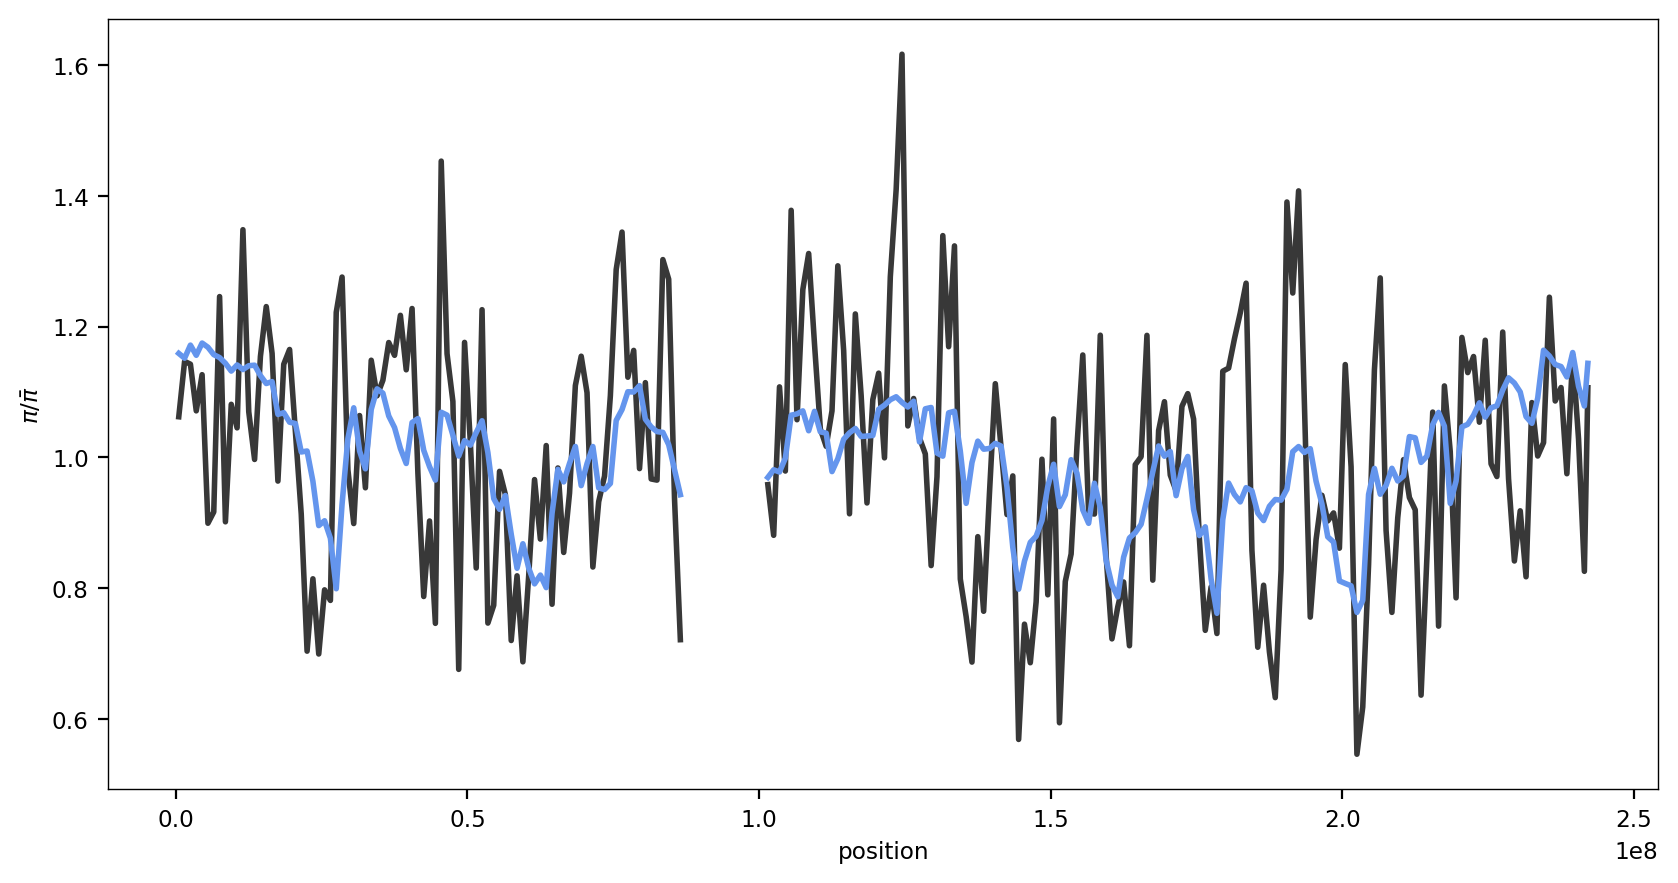

In [200]:
df = d.loc[(d['mu'] == 1.5e-8) & (d['h'] == 0.5) & (d['sh'] == 0.01) & (d['model'] == 'mbp') & (d['model'] == 'mbp') & (d['track_type'] == 'whole genome track')]
df['fit'].tolist()[2].predict_plot('chr2')

Text(0.5, 0, 'simulated mutation rate')

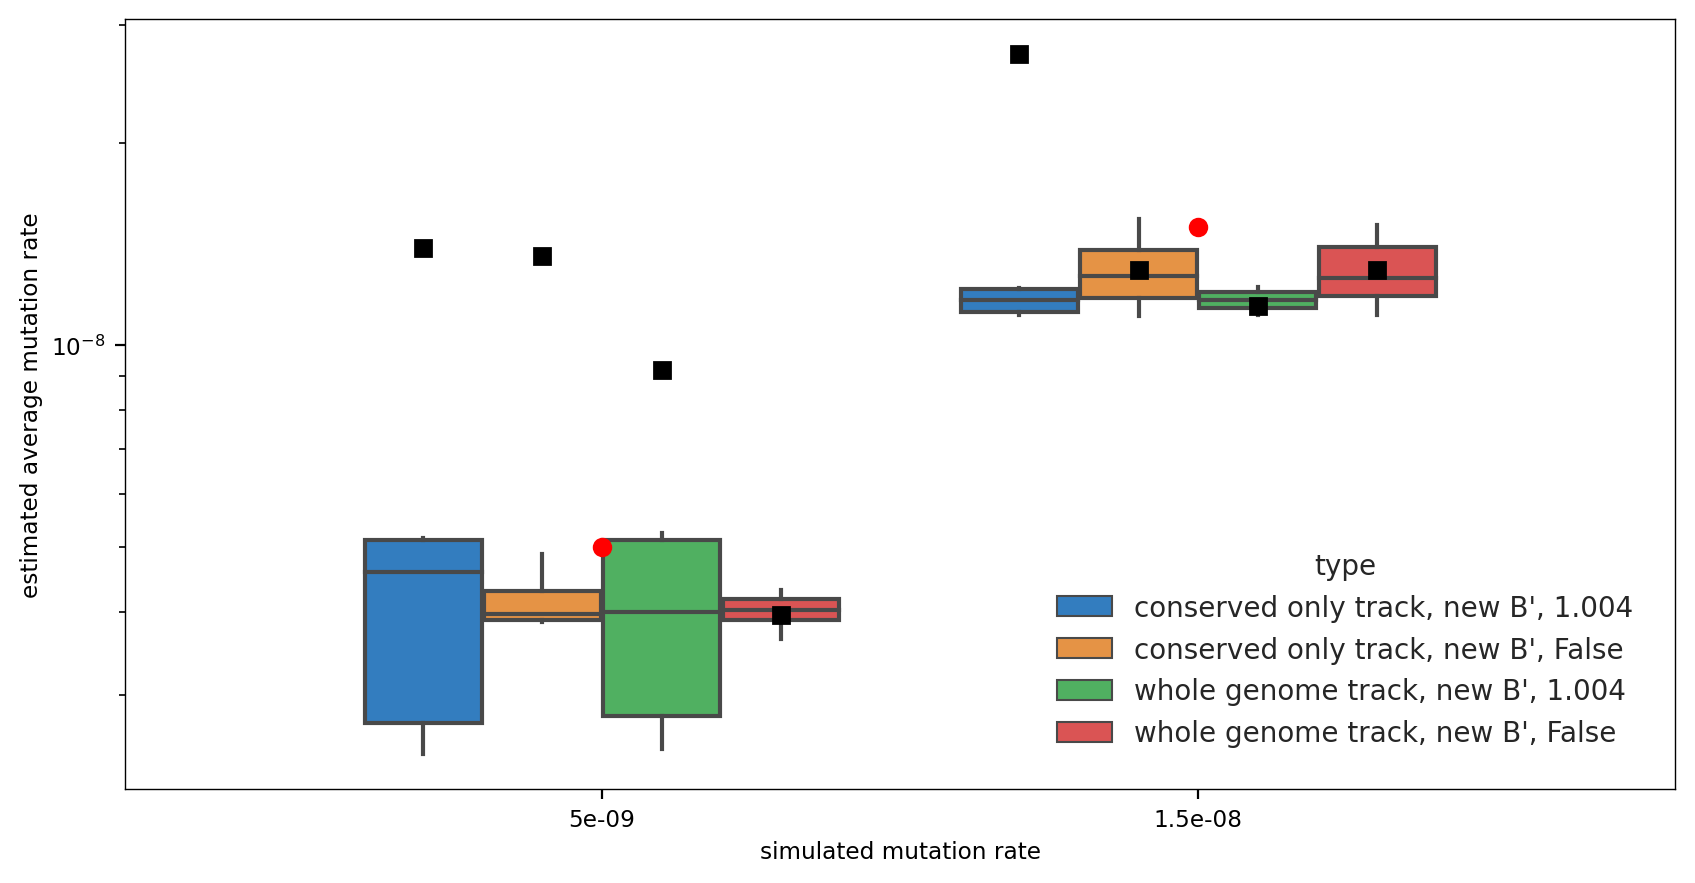

In [234]:
df = d.loc[(d['sh'] == 0.01) & (d['h'] == 0.5) & (d['model'] == 'mbp')]

fig, ax = plt.subplots()
sns.boxplot(x='mu', y='est_mu', data=df, hue='type', ax=ax, showmeans=True)


x = {i: float(x.get_text()) for i, x in enumerate(ax.get_xticklabels())}
ax.scatter(x.keys(), x.values(), c='r')
ax.semilogy()
#ax.semilogx()
ax.set_ylabel('estimated average mutation rate')
ax.set_xlabel('simulated mutation rate')

Text(0.5, 0, 'simulated mutation rate')

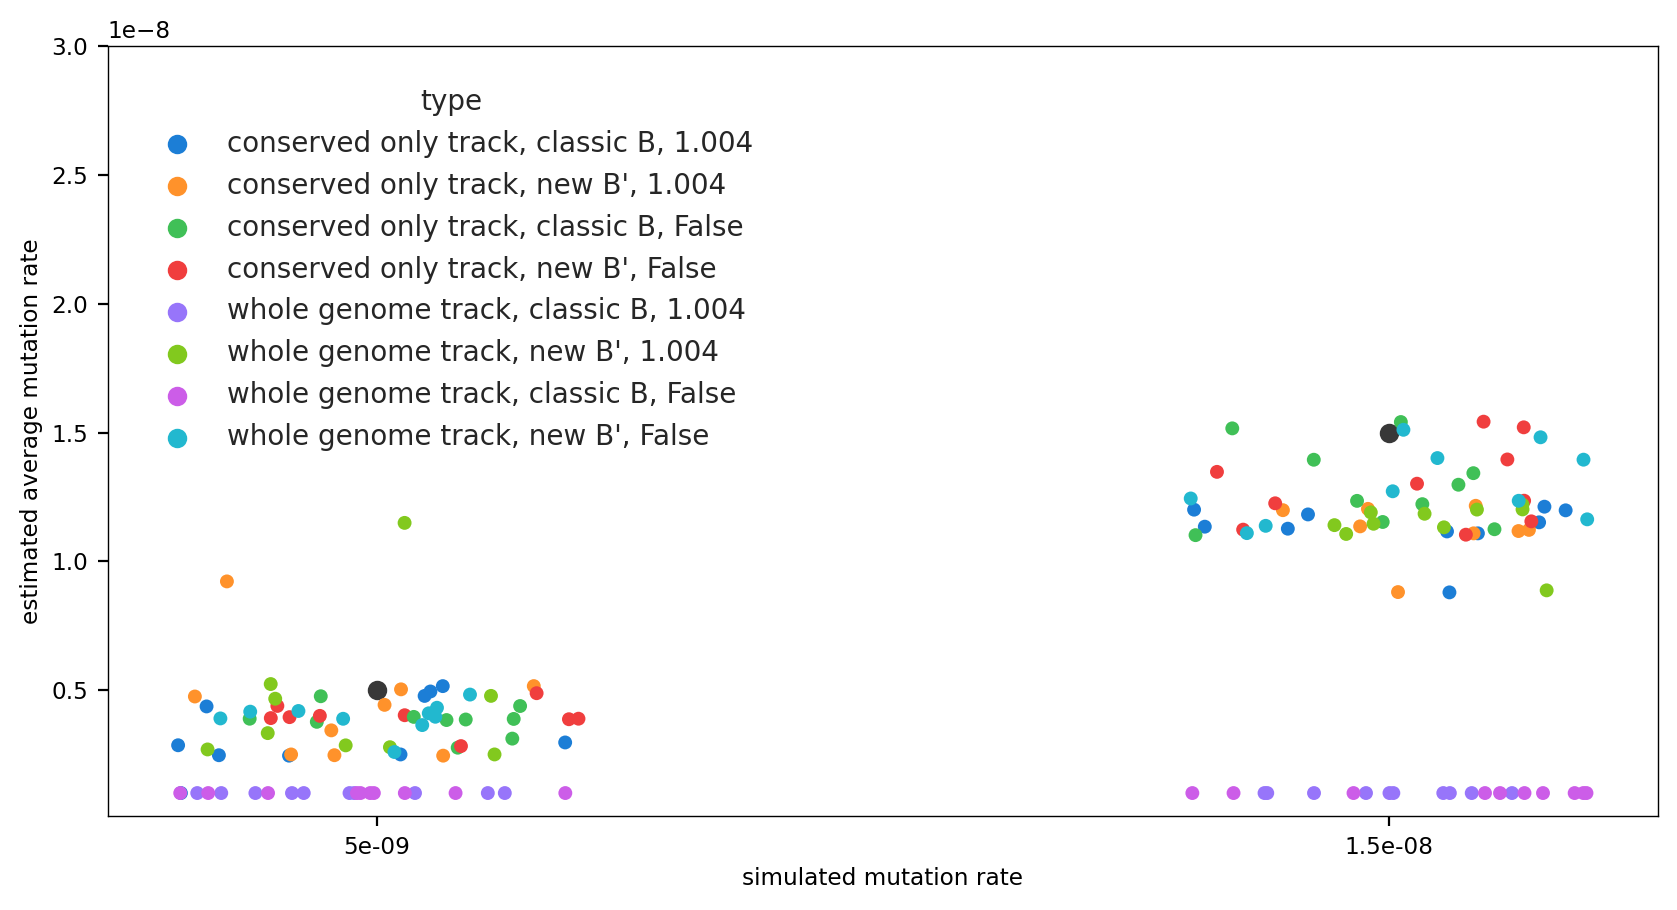

In [294]:
df = d.loc[(d['sh'] == 0.01) & (d['h'] == 0.5)  ]
#df['mu_sh'] = [f'{mu}_{sh}' for mu, sh in zip(df['mu'], df['sh'])]

fig, ax = plt.subplots()
#sns.scatterplot(x='mu', y='est_mu', data=df, hue='type')
sns.stripplot(x="mu", y="est_mu", data=df, hue="type", jitter=0.2)


x = {i: float(x.get_text()) for i, x in enumerate(ax.get_xticklabels())}
ax.scatter(x.keys(), x.values(), c='0.22')
#ax.semilogy()
#ax.semilogx()
ax.set_ylim(0.1e-9, 3e-8)
ax.set_ylabel('estimated average mutation rate')
ax.set_xlabel('simulated mutation rate')

Text(0.5, 0, 'simulated mutation rate')

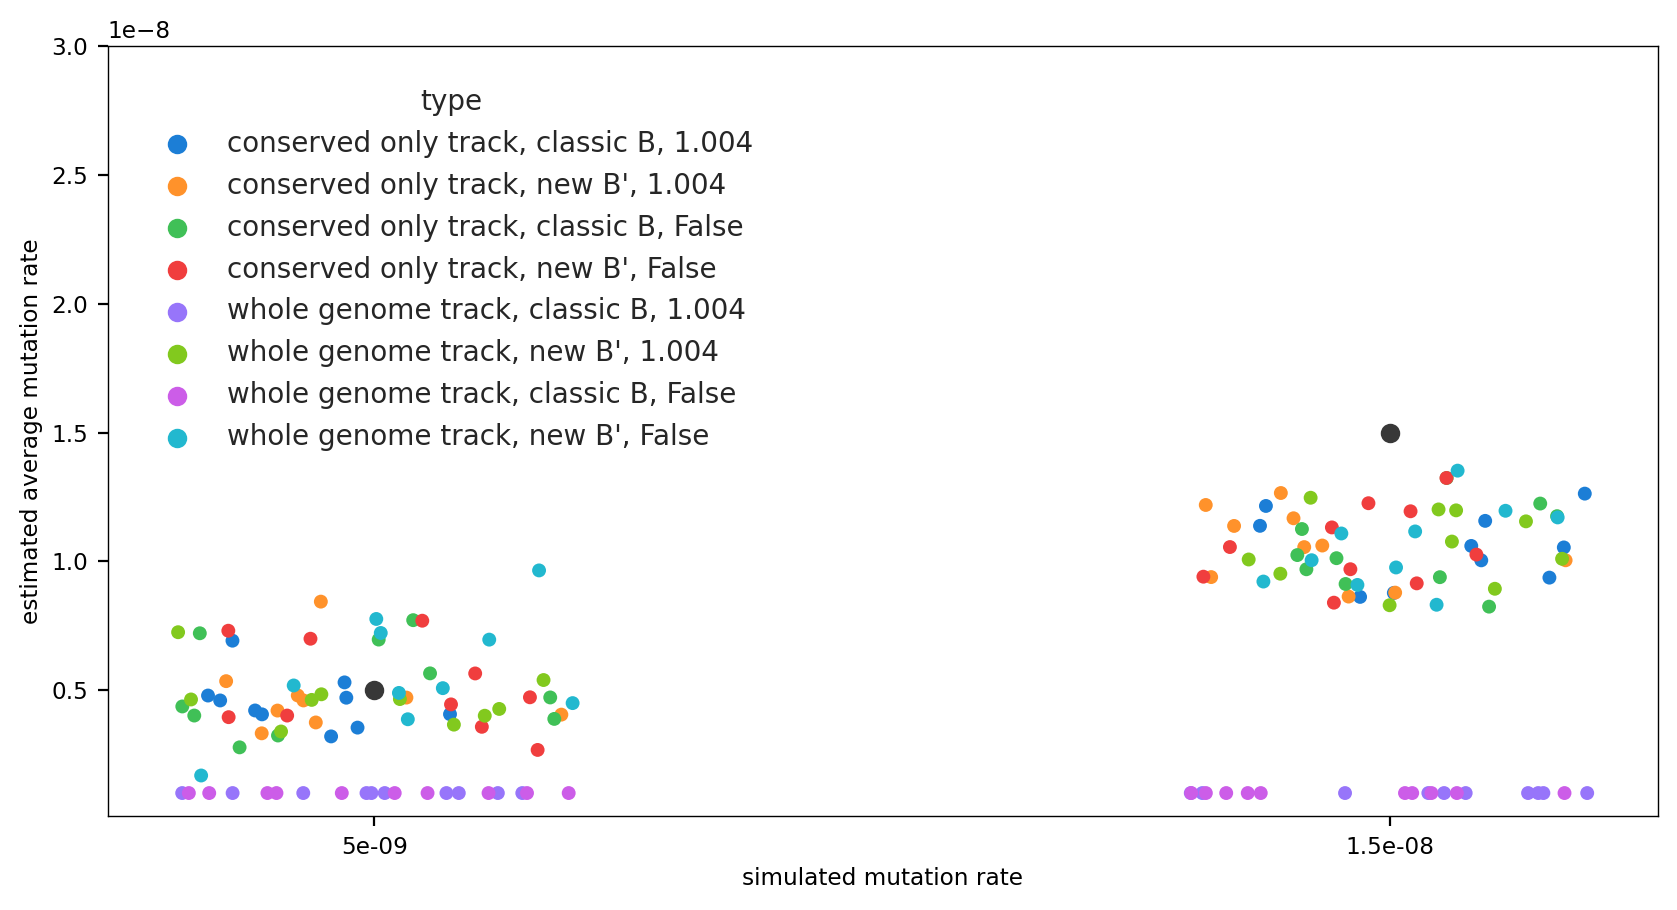

In [291]:
df = d.loc[(d['sh'] == 0.01) & (d['h'] == 0.3)  ]
#df['mu_sh'] = [f'{mu}_{sh}' for mu, sh in zip(df['mu'], df['sh'])]

fig, ax = plt.subplots()
#sns.scatterplot(x='mu', y='est_mu', data=df, hue='type')
sns.stripplot(x="mu", y="est_mu", data=df, hue="type", jitter=0.2)


x = {i: float(x.get_text()) for i, x in enumerate(ax.get_xticklabels())}
ax.scatter(x.keys(), x.values(), c='0.22')
#ax.semilogy()
#ax.semilogx()
ax.set_ylim(0.1e-9, 3e-8)
ax.set_ylabel('estimated average mutation rate')
ax.set_xlabel('simulated mutation rate')

In [20]:
DATADIR = "../data/slim_sims/test/"  # TODO - migrated from old repo, needs rename
result_files = os.listdir(DATADIR)

free_pi0s = list()
fixed_pi0s = list()

for file in result_files:
    filename = os.path.join(DATADIR, file)
    if not filename.endswith("fixedpi0ll.pkl"):
        continue
    with open(filename, 'rb') as f:
        res = pickle.load(f)
    ll, pi0, pi0_ll, pi0_grid, ws, ts, binned_B, binned_pi, gwpi, pi0_mle, w_mle, t_mle, wi_mle, ti_mle, md = res
    fixed_pi0s.append(dict(N=int(md['N']), t=float(md['s'])*float(md['h']), mu=float(md['mu']), pi0=pi0, pi0_mle=pi0_mle, t_mle=t_mle[0], w_mle=w_mle[0]))
    
    
for file in result_files:
    filename = os.path.join(DATADIR, file)
    if not filename.endswith("freepi0ll.pkl"):
        continue
    with open(filename, 'rb') as f:
        res = pickle.load(f)
    ll, pi0, pi0_ll, pi0_grid, ws, ts, binned_B, binned_pi, gwpi, pi0_mle, w_mle, t_mle, wi_mle, ti_mle, md = res
    free_pi0s.append(dict(N=int(md['N']), t=float(md['s'])*float(md['h']), mu=float(md['mu']), pi0=pi0, pi0_mle=pi0_mle, t_mle=t_mle[0], w_mle=w_mle[0]))

ModuleNotFoundError: No module named 'models'

In [6]:
dfree = pd.DataFrame(free_pi0s)
dfixed = pd.DataFrame(fixed_pi0s)
dfree.head()

,N,t,mu,pi0,pi0_mle,t_mle,w_mle
0,1000,-0.00500,1.500000e-08,0.000588,0.000588,0.006237,9.102982e-09
1,1000,-0.00001,2.000000e-08,0.001141,0.001141,0.562341,1.676833e-09
2,1000,-0.05000,1.500000e-08,0.000411,0.000411,0.088105,2.329952e-08
3,1000,-0.10000,1.500000e-08,0.000595,0.000595,0.088105,1.599859e-08
4,1000,-0.00500,2.000000e-08,0.000407,0.000407,0.004786,5.179475e-09


In [7]:
dfree['w_re'] = rel_error(dfree['mu'], dfree['w_mle'])

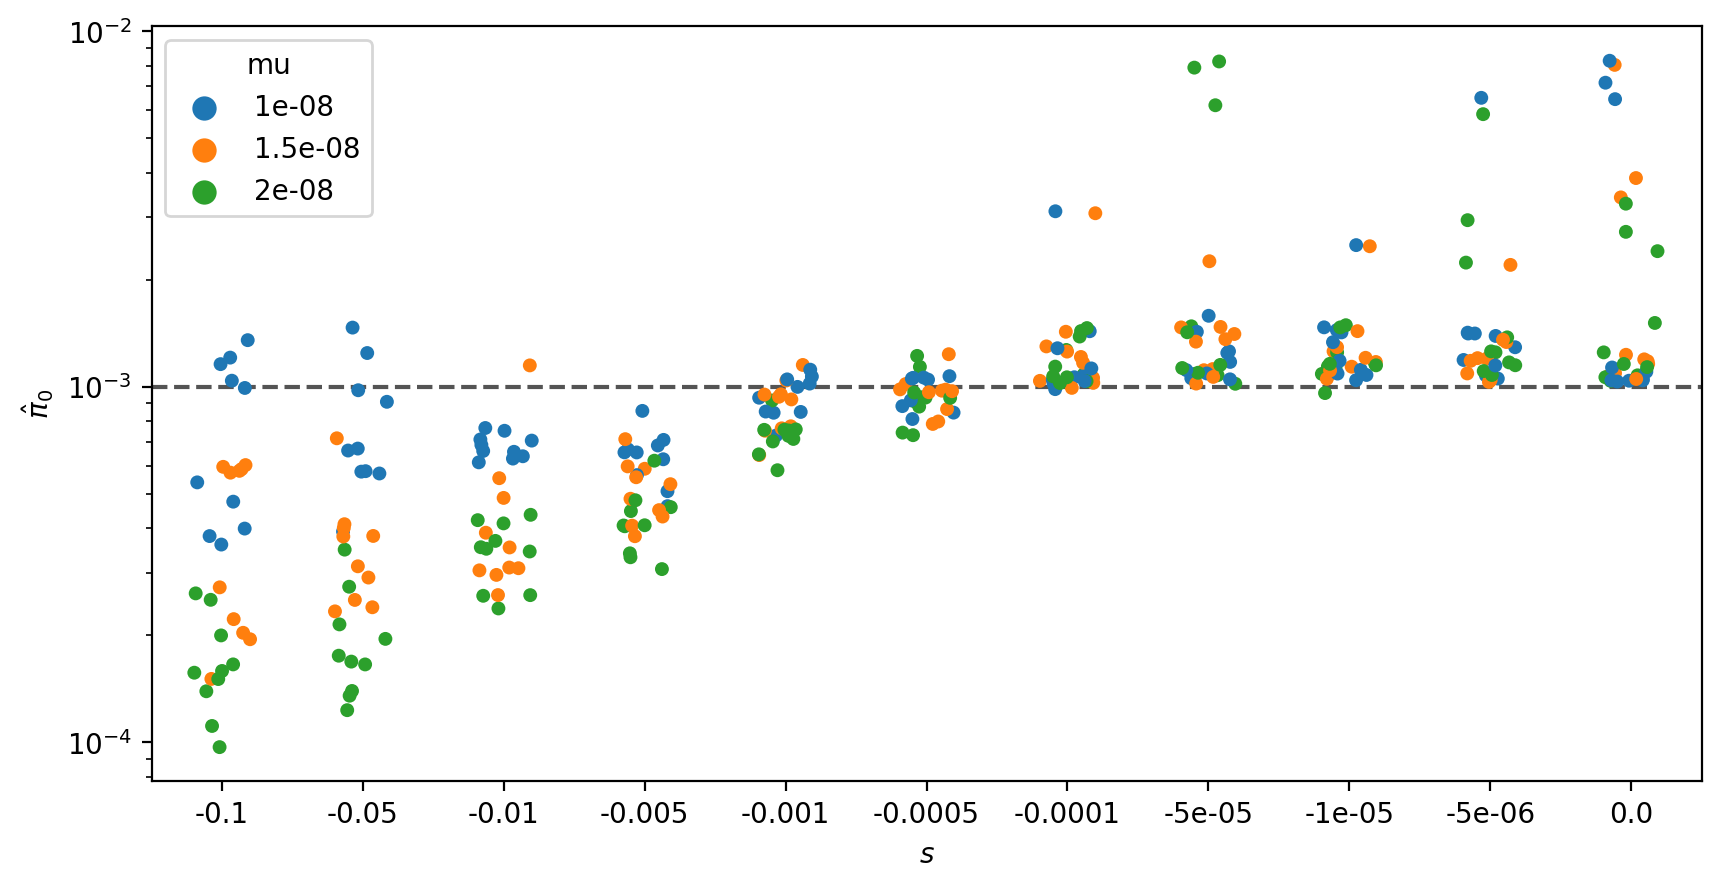

In [8]:
fig, ax = plt.subplots()

sns.stripplot(x="t", y="pi0_mle", data=dfree, hue="mu", jitter=0.2, ax = ax)

ax.axhline(4 * 2.5e-7*1000, c='0.33', linestyle='dashed')
ax.set_yscale('log')
ax.set_ylabel('$\\hat{\\pi}_0$')
ax.set_xlabel('$s$')
#fig.savefig('/home/vsb/pi0.pdf')

## Mutation rate estimation

### Fixed π0

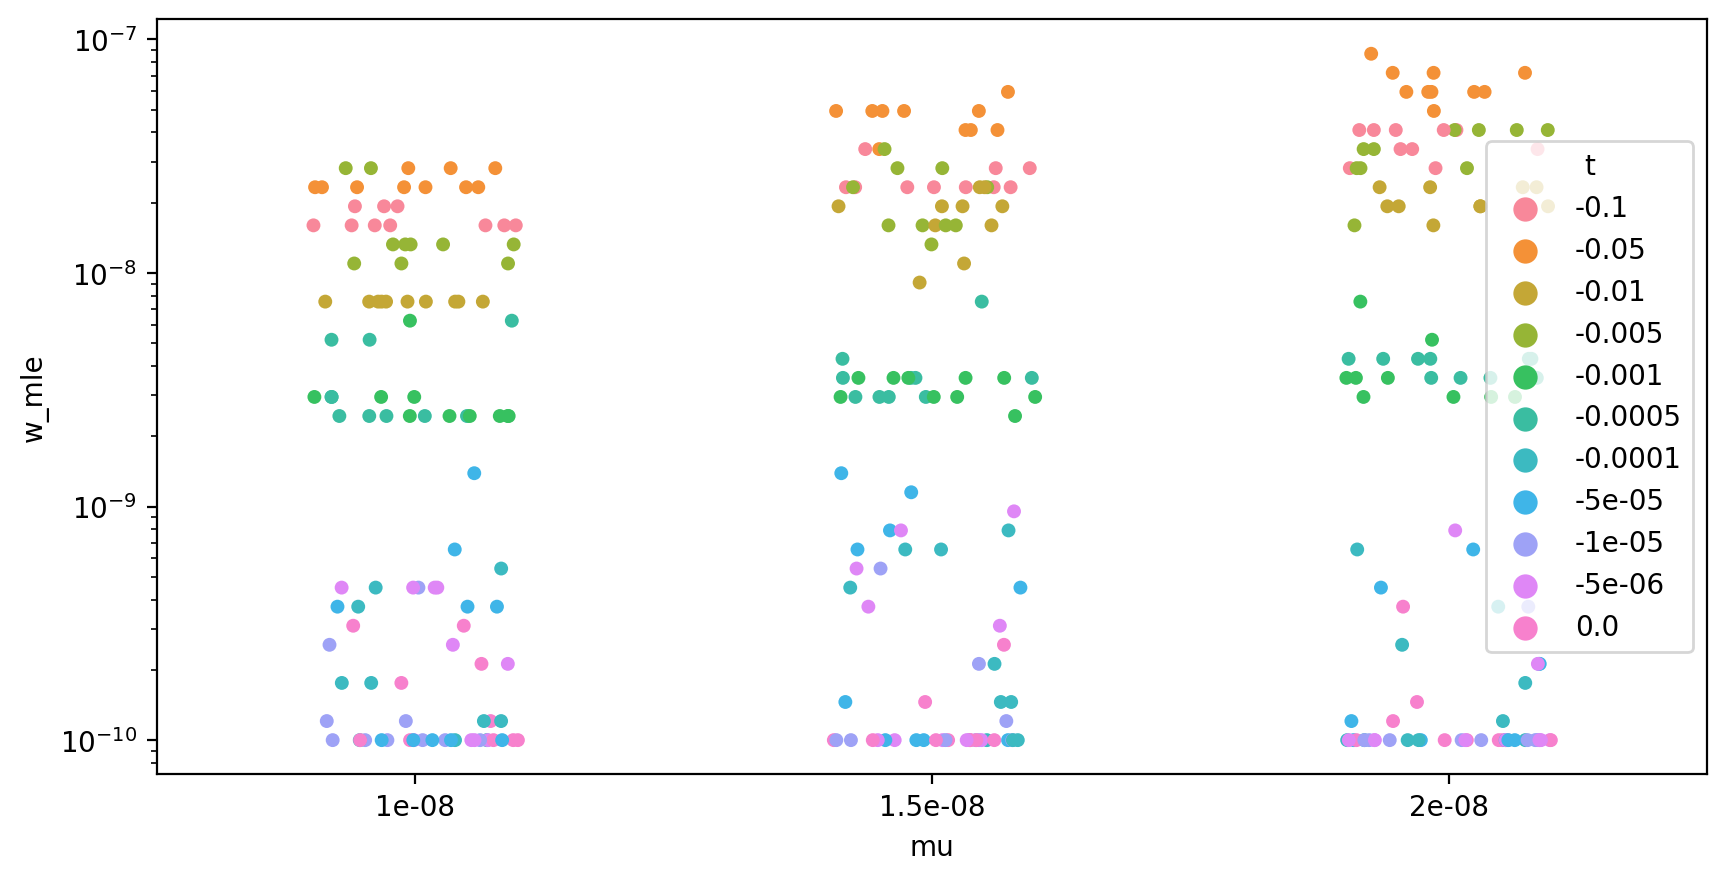

In [31]:
fig, ax = plt.subplots()

sns.stripplot(x="mu", y="w_mle", data=dfixed, hue="t", jitter=0.2, ax = ax)

#ax.axhline(4 * 2.5e-7*1000, c='r')
ax.set_yscale('log')

### Free π0

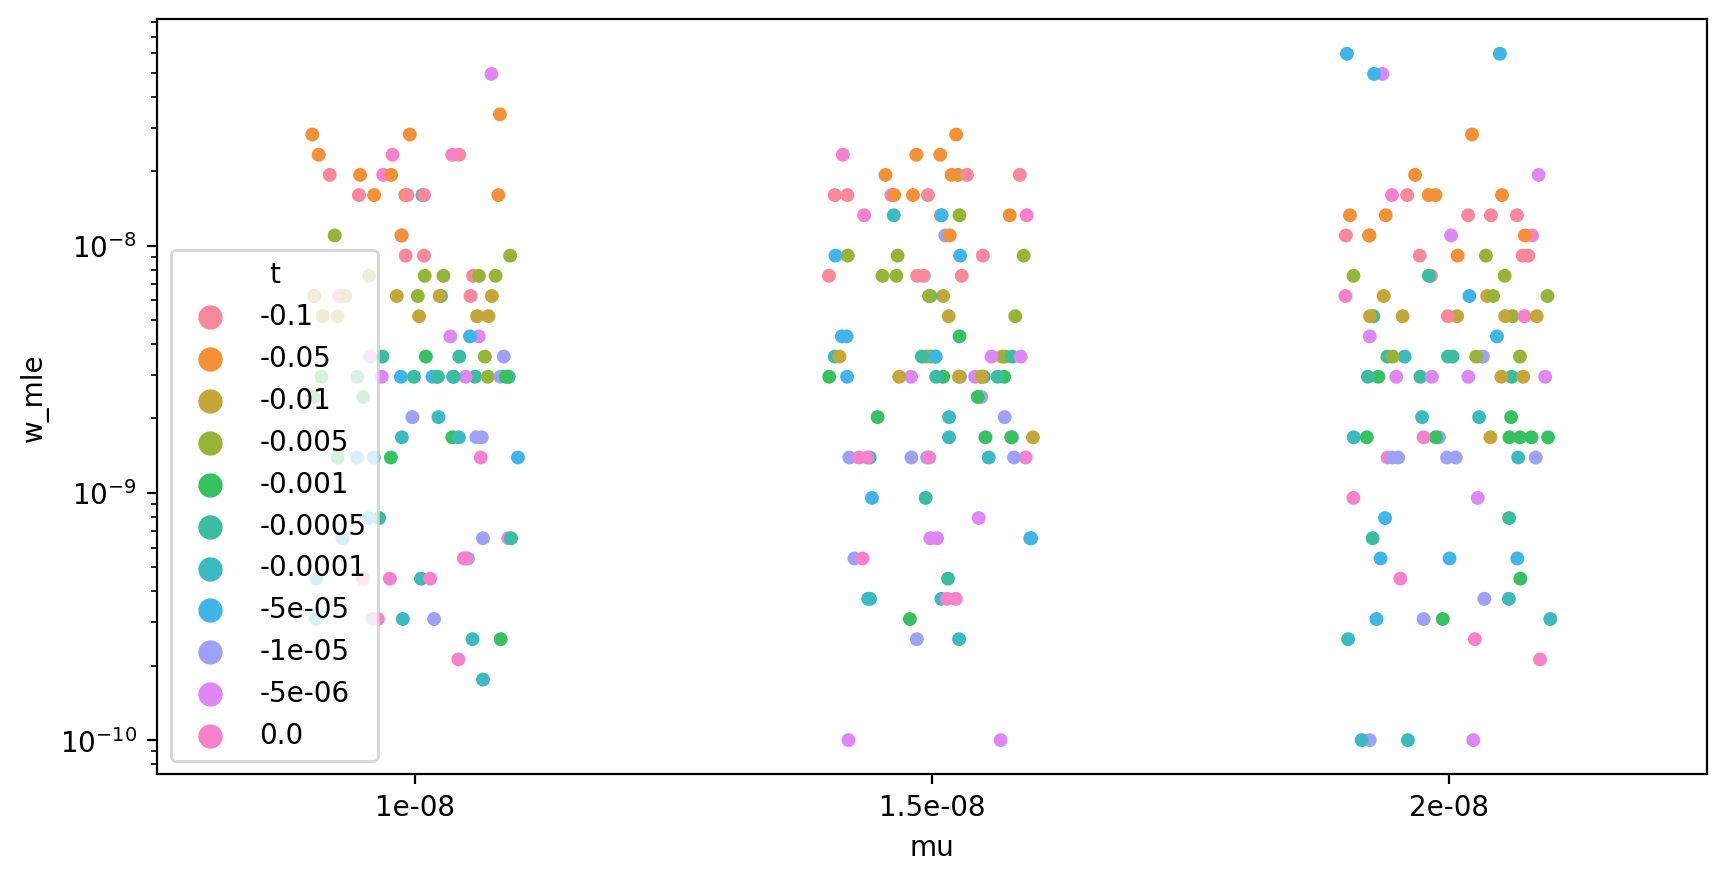

In [32]:
fig, ax = plt.subplots()

sns.stripplot(x="mu", y="w_mle", data=dfree, hue="t", jitter=0.2, ax = ax)

#ax.axhline(4 * 2.5e-7*1000, c='r')
ax.set_yscale('log')

## Selection coefficient estimation

### Free π0

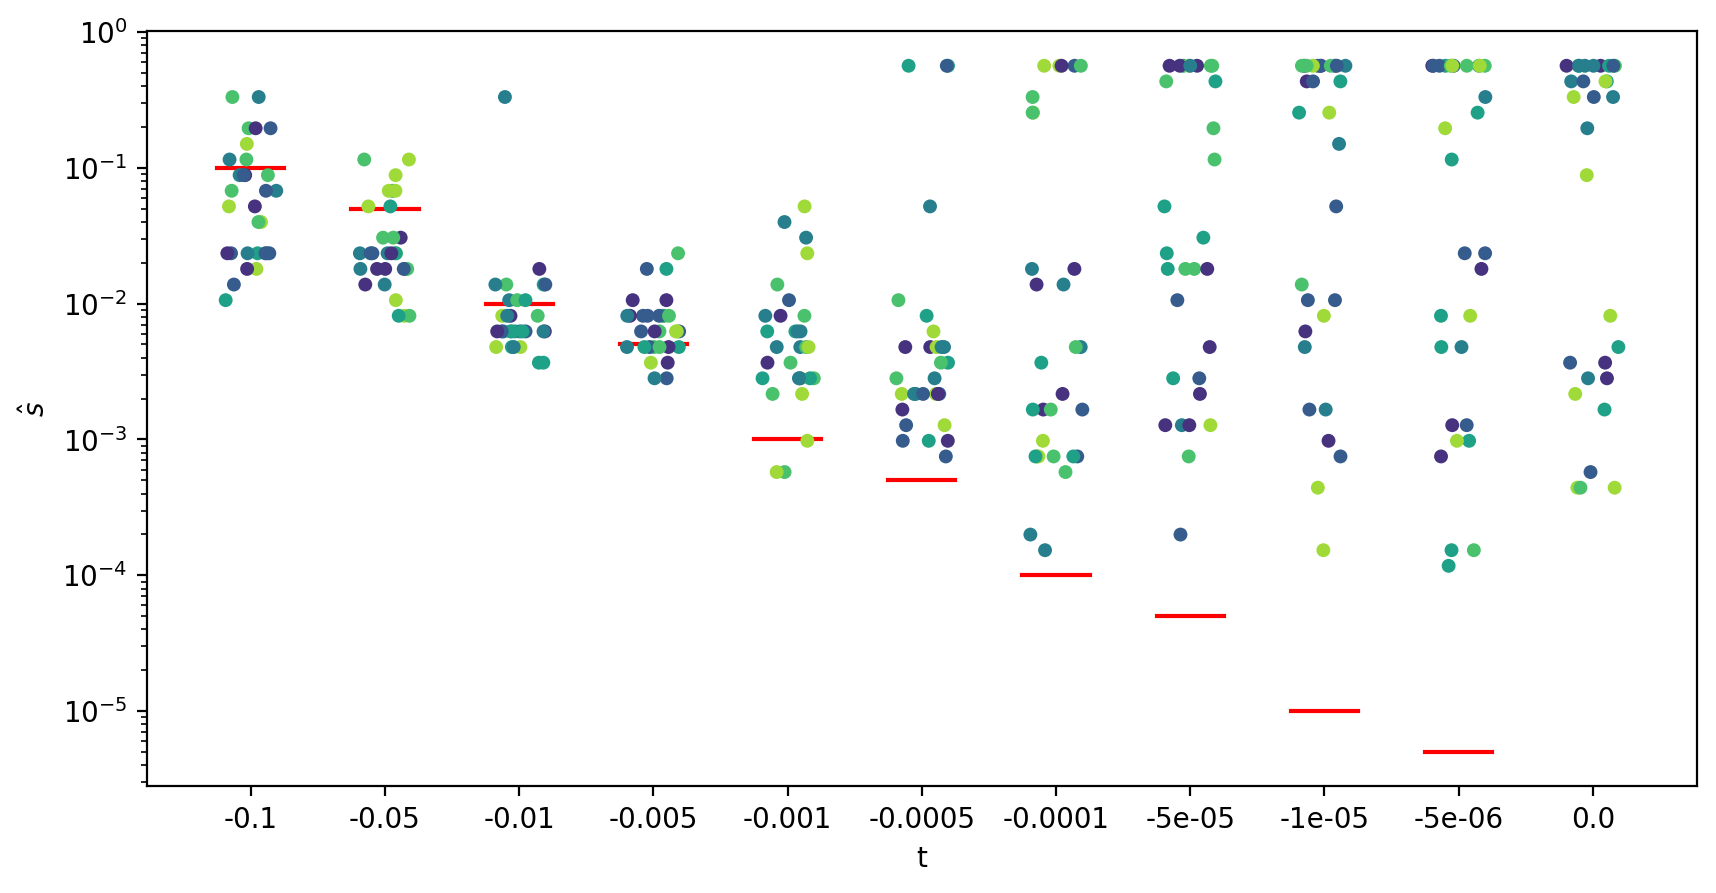

In [97]:
fig, ax = plt.subplots()
cpal = sns.color_palette('viridis')
dfree['pi0_mle_log10'] = np.log10(dfree['pi0_mle'])
sns.stripplot(x="t", y="t_mle", data=dfree, hue="pi0_mle_log10", jitter=0.2, ax=ax, palette=cpal)

median_width = 0.5
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    val = -float(text.get_text())
    ax.plot([tick-median_width/2, tick+median_width/2], [val, val], c='r')
#ax.axhline(4 * 2.5e-7*1000, c='r')
ax.get_legend().remove()
ax.set_yscale('log')
ax.set_ylabel('$\hat{s}$')
#ax.legend()
#fig.colorbar(cmap)
fig.savefig('/home/vsb/s_hat.pdf')


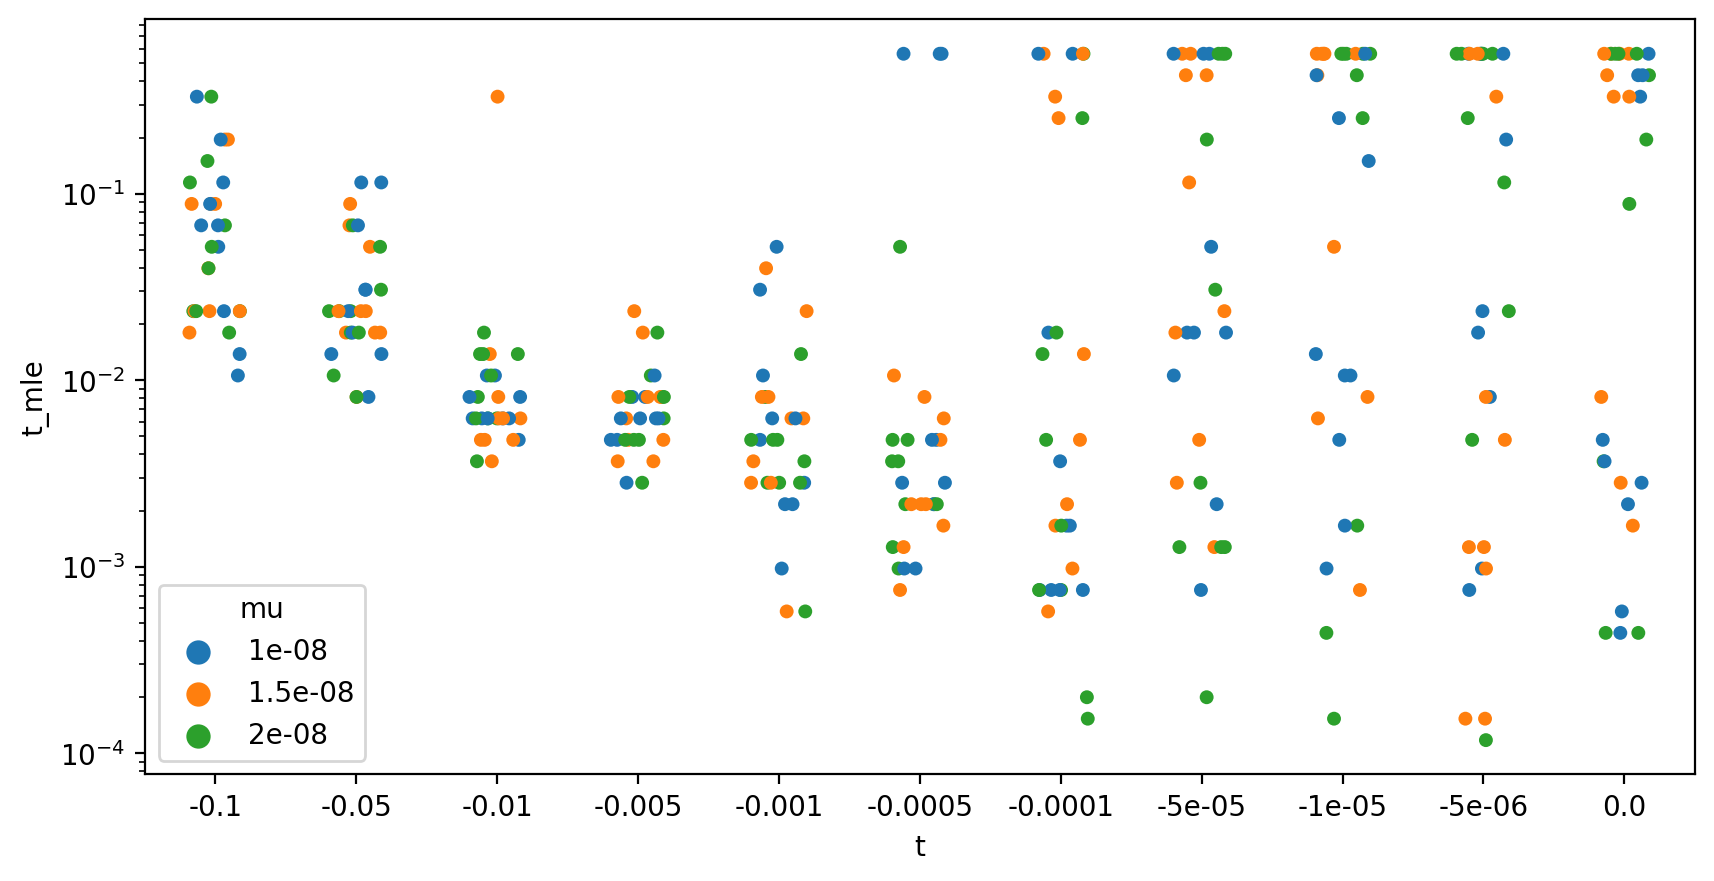

In [54]:
fig, ax = plt.subplots()
cmap = sns.cubehelix_palette(as_cmap=True)

sns.stripplot(x="t", y="t_mle", data=dfree, hue="mu", cmap=cmap, jitter=0.2, ax = ax)

#ax.axhline(4 * 2.5e-7*1000, c='r')
#ax.get_legend().remove()
ax.set_yscale('log')
#fig.colorbar(cmap)


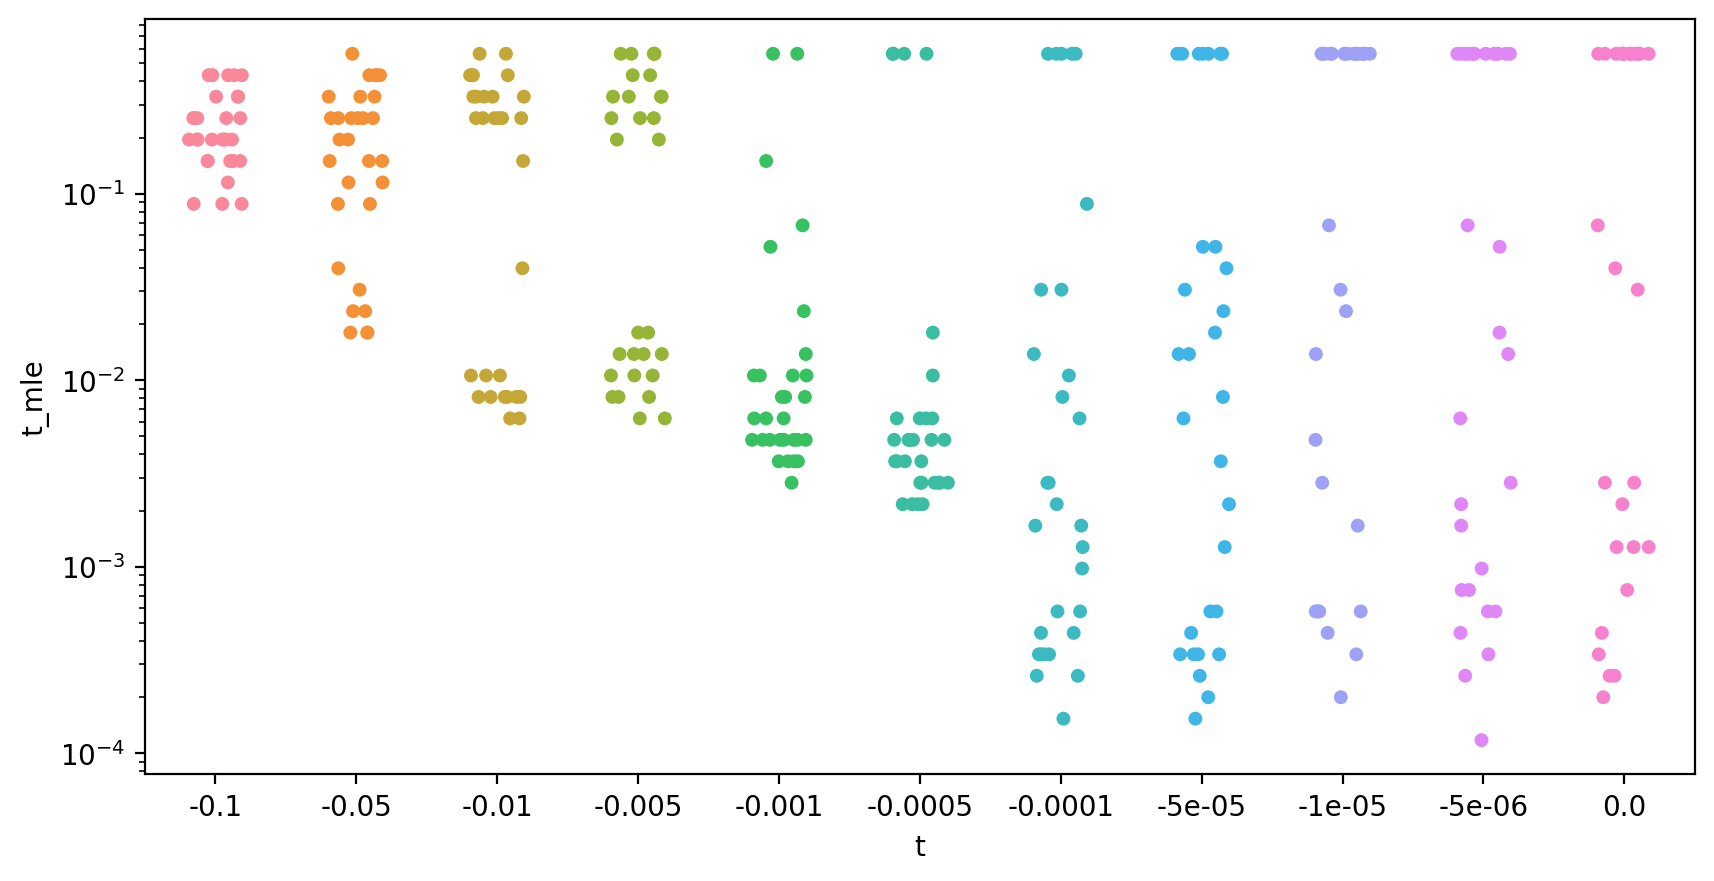

In [34]:
fig, ax = plt.subplots()
cmap = sns.cubehelix_palette(as_cmap=True)

sns.stripplot(x="t", y="t_mle", data=dfixed, cmap=cmap, jitter=0.2, ax = ax)

#ax.axhline(4 * 2.5e-7*1000, c='r')
ax.set_yscale('log')
#fig.colorbar(cmap)


In [137]:
130000000 * 2.5e-7 * 1000 * 4

130000.0

In [14]:
ll, pi0, pi0_ll, pi0_grid, ws, ts, binned_B, binned_pi, gwpi, pi0_mle, w_mle, t_mle, wi_mle, ti_mle, md = res

In [18]:
pi0, pi0_mle

(0.0011481496987360924, 0.0011481496987360924)

In [19]:
md

{'N': '1000',
 'annot_file': '../data/annotation/conserved_chr10.bed',
 'h': '0.5',
 'mu': '1e-08',
 'recmap_file': '../data/annotation/rec_100kb_chr10.bed',
 'region_length': '130000000',
 's': '-1e-05'}